# Part 1: Fully Connected Layers

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

## Load the Data

In [1]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('MLBD-dataset-yahtzee.csv')
raw_df.head() 

dice1  dice2  dice3  dice4  dice5           label
0      3      6      6      2      5         nothing
1      3      6      1      3      4         nothing
2      2      2      5      5      3         nothing
3      1      3      6      6      1         nothing
4      1      4      6      3      5  small-straight

## Analyse the Data

In [2]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dice1   5832 non-null   int64 
 1   dice2   5832 non-null   int64 
 2   dice3   5832 non-null   int64 
 3   dice4   5832 non-null   int64 
 4   dice5   5832 non-null   int64 
 5   label   5832 non-null   object
dtypes: int64(5), object(1)
memory usage: 273.5+ KB


We see that there are no null values and all data sets are therefore complete

### How balanced is our data set?

In [3]:
count_values = raw_df.groupby(['label'])['label'].count()
count_values

label
four-of-a-kind      116
full-house          221
large-straight      178
nothing            3868
small-straight      549
three-of-a-kind     896
yathzee               4
Name: label, dtype: int64

### Result of analysing

We see a very unbalanced data set. One rubric stands out particularly strongly. The number of "yathzee's" is just 4. According to the rules of the game, a "yathzee" occurs when all dice show the same number. So we add the missing records.

In [4]:
raw_df[raw_df['label'] == 'yathzee']

dice1  dice2  dice3  dice4  dice5    label
1101      5      5      5      5      5  yathzee
1180      2      2      2      2      2  yathzee
1602      6      6      6      6      6  yathzee
5504      3      3      3      3      3  yathzee

In [5]:
df = raw_df.copy()

df.loc[len(df.index)] = [1,1,1,1,1,'yathzee']
df.loc[len(df.index)] = [4,4,4,4,4,'yathzee']

## Extract the data

How to split the dataset into Features=X and Target=Y. We also convert the strings in our target column to numbers, since a model works better with numbers. Also the one-hot encoding is in this step.

Class=0, n=3868 (66.301%)
Class=1, n=549 (9.410%)
Class=2, n=896 (15.358%)
Class=3, n=178 (3.051%)
Class=4, n=221 (3.788%)
Class=5, n=116 (1.988%)
Class=6, n=6 (0.103%)


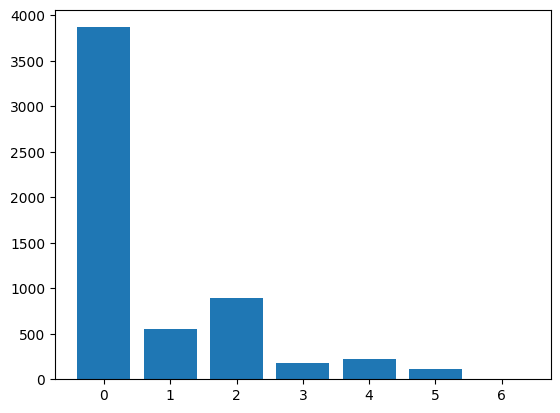

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_for_this_cell = df #bal_df

y_labels = df_for_this_cell.label.unique()
df.label = pd.factorize(df.label)[0]

features = []
for feature in df_for_this_cell.columns:
    if feature != 'label':
        features.append(feature)
        
X = df_for_this_cell[features]
y = df_for_this_cell['label']

y_encoded = LabelEncoder().fit_transform(y)

counter = Counter(y_encoded)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
plt.bar(counter.keys(), counter.values())
plt.show()

## Cross validation - split the dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Normalize the data - keras loves to work with numbers between 0 and 1

In [8]:
import tensorflow as tf
from tensorflow import keras

def normalize_for_keras(data):
    return tf.keras.utils.normalize(data, axis=1)

X_train_raw = X_train
X_test_raw = X_test
X_train = normalize_for_keras(X_train)
X_test =  normalize_for_keras(X_test)

2023-02-02 15:42:46.152799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3101,  425,  721,  146,  173,   97,    4]))

In [10]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([767, 124, 175,  32,  48,  19,   2]))

## Balancing the data

In order to train our model better, we balance our data set. To avoid overfitting we do this after splitting the data into training and test data. Although the values are then somewhat worse (we have done several tests), our model is more robust this way.

We first determine the median of the number of different classes. Then we apply undersampling to all classes that are above the median. For all data below the median we use oversampling.

In [11]:
train_n_samples = int(round(np.unique(y_train, return_counts=True)[1].mean()))
test_n_samples = int(round(np.unique(y_test, return_counts=True)[1].mean()))
print(train_n_samples)
print(test_n_samples)

667
167


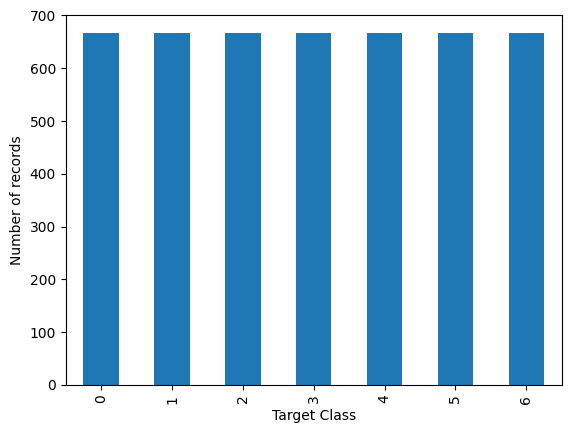

In [12]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train, y_train, train_n_samples, t='majority'))
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_train_under, y_train_under, train_n_samples, t='minority'), k_neighbors=3)

X_train_bal, y_train_bal = over_sampler.fit_resample(X_train_under, y_train_under)

count = y_train_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

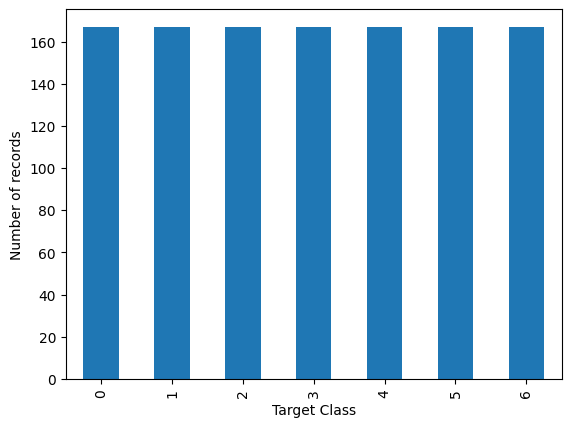

In [13]:
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_test, y_test, test_n_samples, t='majority'))
X_test_under, y_test_under = under_sampler.fit_resample(X_test, y_test)

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_test_under, y_test_under, test_n_samples, t='minority'), k_neighbors=1)

X_test_bal, y_test_bal = over_sampler.fit_resample(X_test_under, y_test_under)

count = y_test_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

## Load the important libarys

In [14]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Nadam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Normalization
from tensorflow.keras.callbacks import History, TensorBoard
from sklearn.utils import class_weight

### Normalize X values for keras

In [15]:
normalizer = keras.layers.Normalization()
normalizer.adapt(X_train_bal)
normalizer.adapt(X_test_bal)

2023-02-02 15:42:52.533015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define methods for evaluate, create and fill a model

In [16]:
def evaluat_my_model(model, input_data, output_data):
    
    output_data = output_data.values.reshape(-1,1)
    output_data = tf.keras.utils.to_categorical(output_data, np.unique(output_data).size)
    
    evaluation_results = model.evaluate(input_data, output_data)

    return evaluation_results

In [17]:
# variable to save all the params for each model in this notebook
models = []

# Valid command to create a model with 2 hidden layers and 1 dropout layer:
# model = create_mode(X, y, [(300,"relu"),(210,"relu",0.2)] )
# 
# After every hidden layer will be add a normalize layer
#
# The loss function is the categorical_crossentropy from keras for multi category
#
def create_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", learningRate = 0.0001):
    
    inputNeurons = input_data.shape[1]
    outputNeurons = np.unique(output_data).size
    
    model = Sequential()
    
    firstLayer = True
    
    for layer in layers:
        if(firstLayer):
            model.add(Dense(layer[0], input_shape=(inputNeurons,), activation=layer[1]))
            firstLayer = False
        else:
            model.add(Dense(layer[0], activation=layer[1]))
            
        model.add(BatchNormalization())
        
        if(2 < len(layer)):
            model.add(Dropout(layer[2]))
    
    model.add(Dense(outputNeurons, activation=endActi))
    
    if optimizer == "adam":
        opti = Adam(learning_rate=learningRate)
    elif optimizer == "nadam":
        opti = Nadam(learning_rate=learningRate)
    elif optimizer == "sgd":
        opti = SGD(learning_rate=learningRate)
    elif optimizer == "adagrad":
        opti = Adagrad(learning_rate=learningRate)
    else:
        opti = optimizer
    
    model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=["accuracy"])
    
    return model

def create_fit_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", learningRate=0.0001, batchSize=128, epochs=250, verbose=0, withHistory=0):
        
        model = create_model(input_data, output_data, layers, optimizer=optimizer, endActi=endActi, learningRate=learningRate)
        
        inputNeurons = input_data.shape[1]
        outputNeurons = np.unique(output_data).size

        # The output classes will transform to categorical
        output_data = output_data.values.reshape(-1,1)
        output_data = tf.keras.utils.to_categorical(output_data, outputNeurons)
        y_test_cat = tf.keras.utils.to_categorical(y_test_bal, outputNeurons)
        
        history = History()
        history = model.fit(x=input_data, y=output_data, batch_size=batchSize, epochs=epochs, verbose=verbose, shuffle=True, validation_split=0.2, callbacks=[history])
        evaluate = evaluat_my_model(model=model, input_data=X_test_bal, output_data=y_test_bal)
        models.append({
            'layers':layers,
            'optimizer':optimizer,
            'batchSize':batchSize,
            'learningRate':learningRate,
            'epochs':epochs,
            'endActi':endActi,
            'best_loss':evaluate[0],
            'best_accuracy':evaluate[1],
            'loss':history.history['loss'],
            'accuracy':history.history['accuracy'],
            'val_accuracy':history.history['val_accuracy']
            })
        
        if withHistory == 1:
            return model, history
        return model

def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

## Create different Models

At this point it should be mentioned that we have performed this step very often. In order to fulfill the individual tasks, the various parameters are set.

The models default create all with adam optimizer and softmax as proper output function, BatchSize is 128 and epochs 250. Also after every layer, not the last layer, comes a BatchNormalization layer.

example:

(300,"relu") - one hidden layer with 300 output neurons with relu activation
(210, 'sigmoid', 0.2) - one hidden layer with 210 output neurons with sigmoid activation and after 0.2 Dropout

neuron test:
- (10,"relu")
- (100,"relu")
- (1000,"relu")
- (10000,"relu")

activation function test:
- (500,"relu")
- (500,"tanh")
- (500,"sigmoid")

more layer (random):

- (100,"relu"), (200,"relu")
- (500,"relu"), (300,"relu"), (100,"relu"), (50,"relu")
- (100,"relu"), (200,"tanh")
- (500,"relu"), (300,"relu"), (100,"tanh"), (50,"relu")
- (100,"relu"), (200,"sigmoid")
- (500,"relu"), (300,"relu"), (100,"sigmoid"), (50,"relu")

same layer like before with random fix dropout:

- (100,"relu"), (200,"relu", 0.2)
- (500,"relu"), (300,"relu", 0.3), (100,"relu", 0.25), (50,"relu")
- (100,"relu"), (200,"tanh", 0.2)
- (500,"relu"), (300,"relu", 0.3), (100,"tanh", 0.25), (50,"relu")
- (100,"relu"), (200,"sigmoid", 0.2)
- (500,"relu"), (300,"relu", 0.3), (100,"sigmoid", 0.25), (50,"relu")

37/37 [==============================] - 0s 517us/step - loss: 2.1796 - accuracy: 0.1694


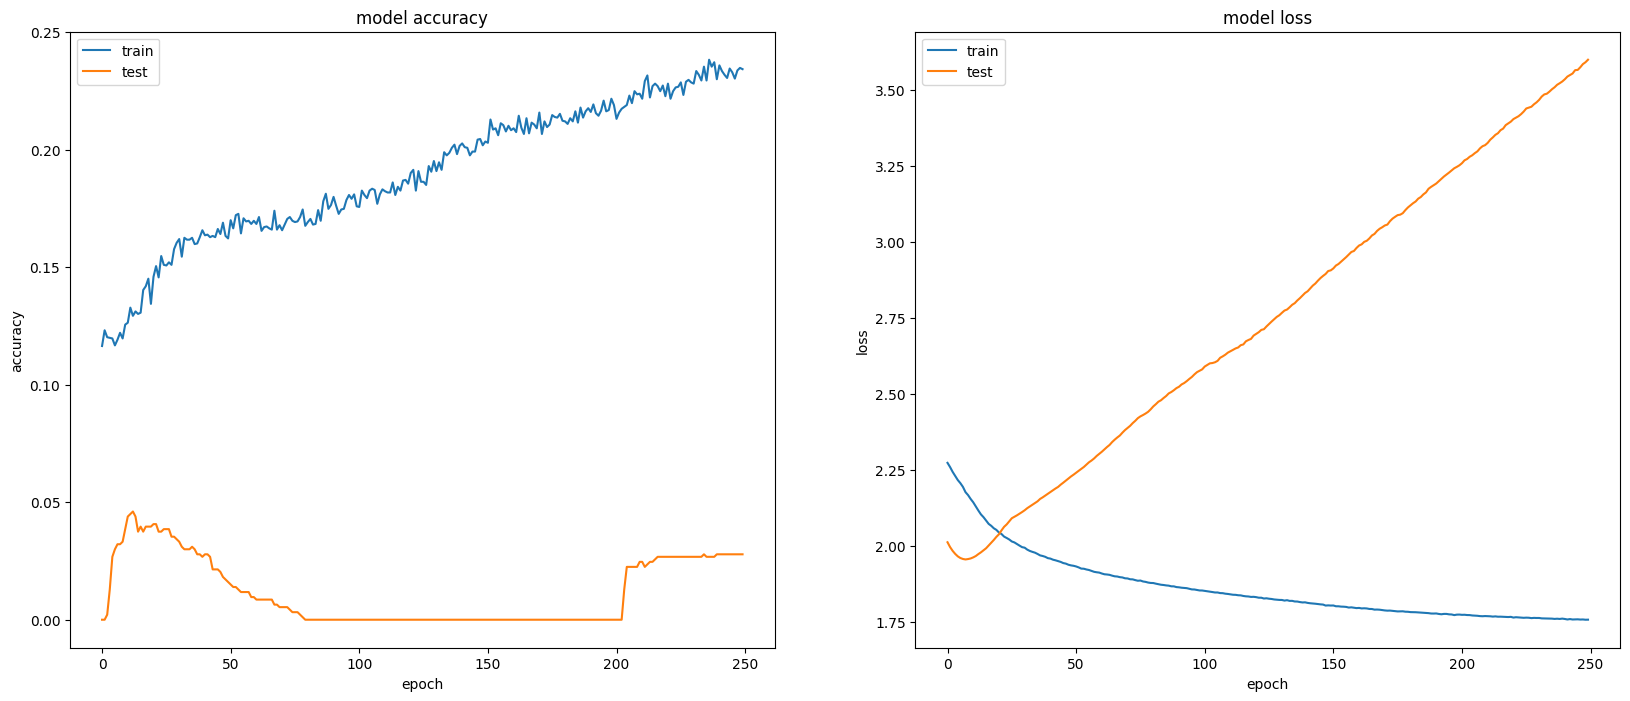

In [18]:
layers = [(10,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 476us/step - loss: 2.1772 - accuracy: 0.2464


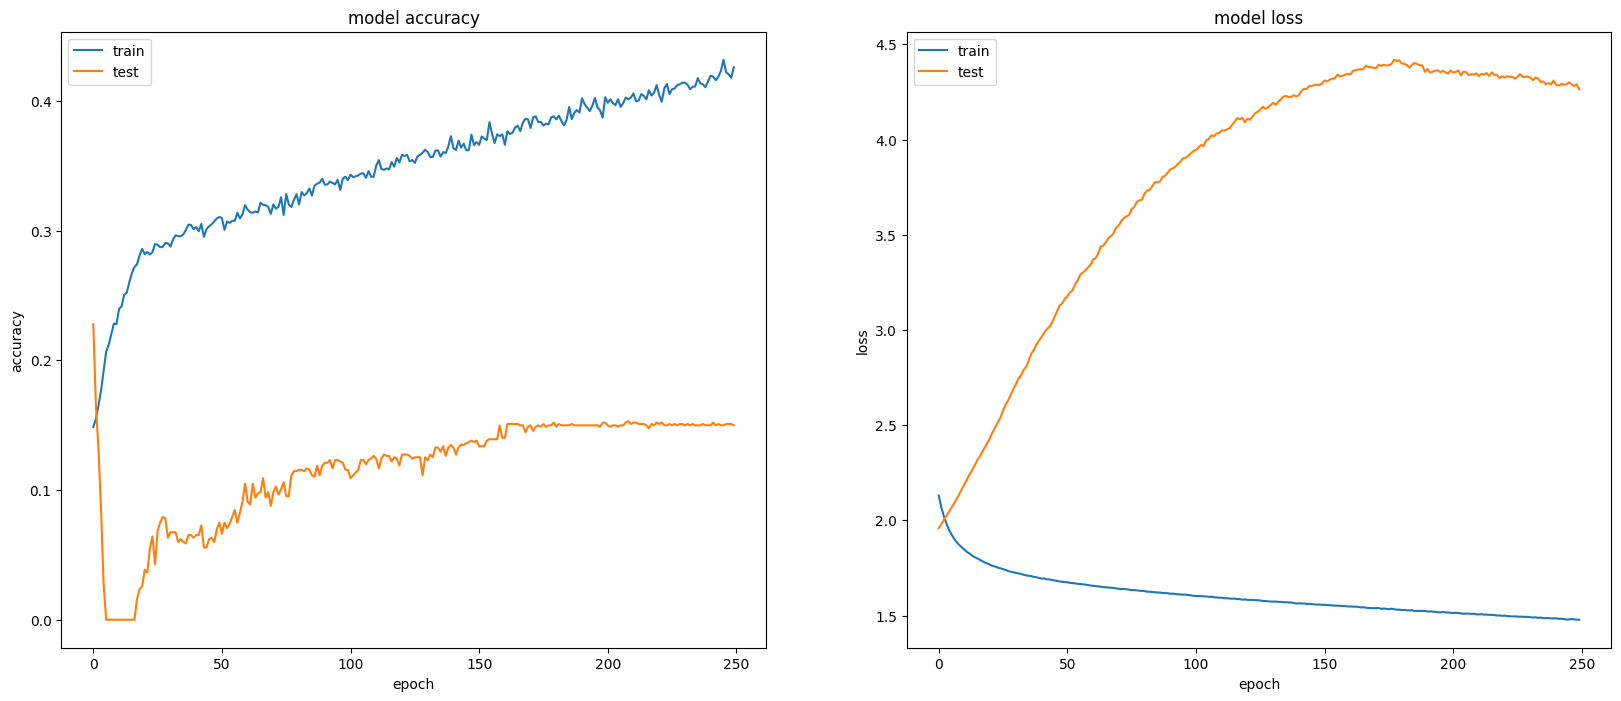

In [19]:
layers = [(100,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 580us/step - loss: 1.5982 - accuracy: 0.3901


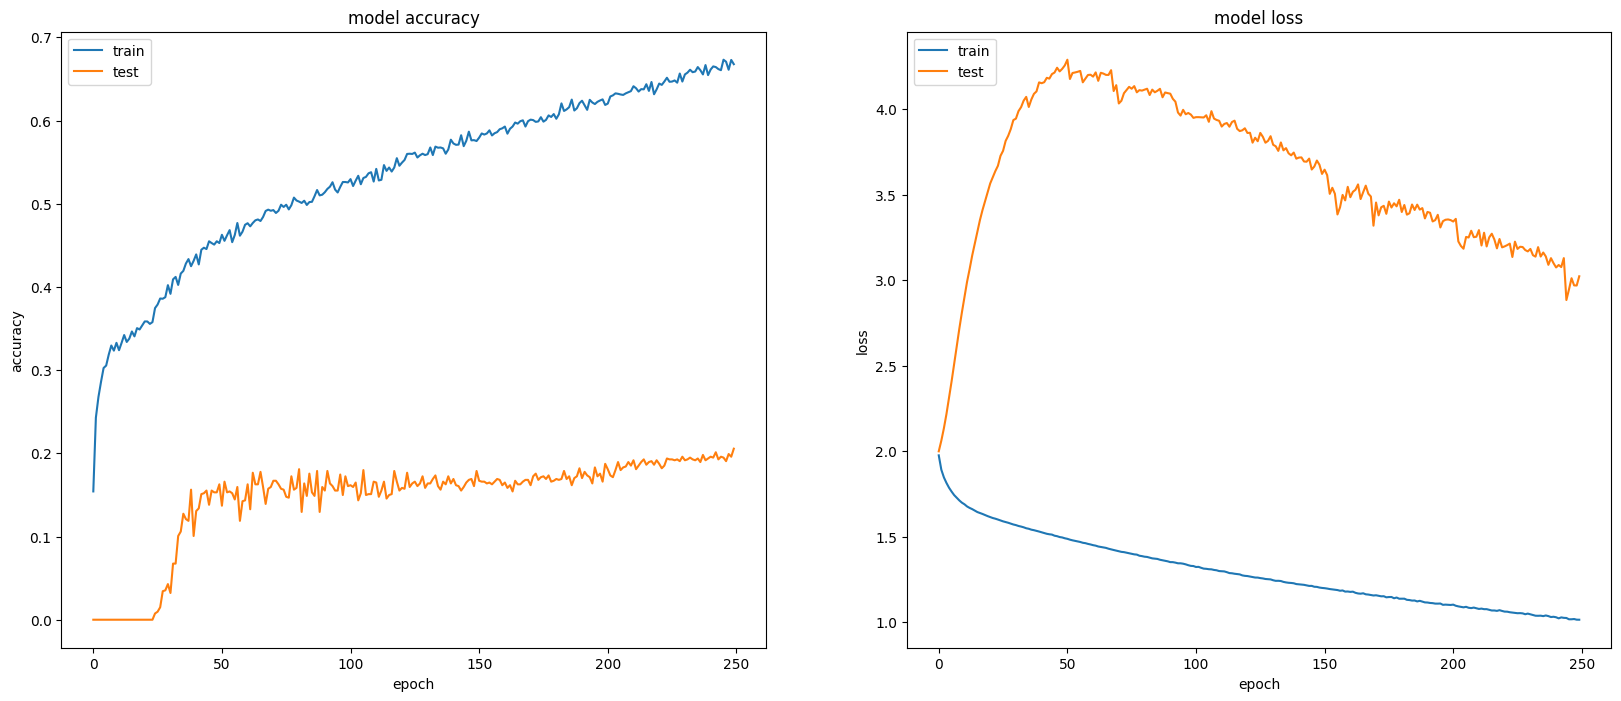

In [20]:
layers = [(1000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 1ms/step - loss: 0.8818 - accuracy: 0.5766


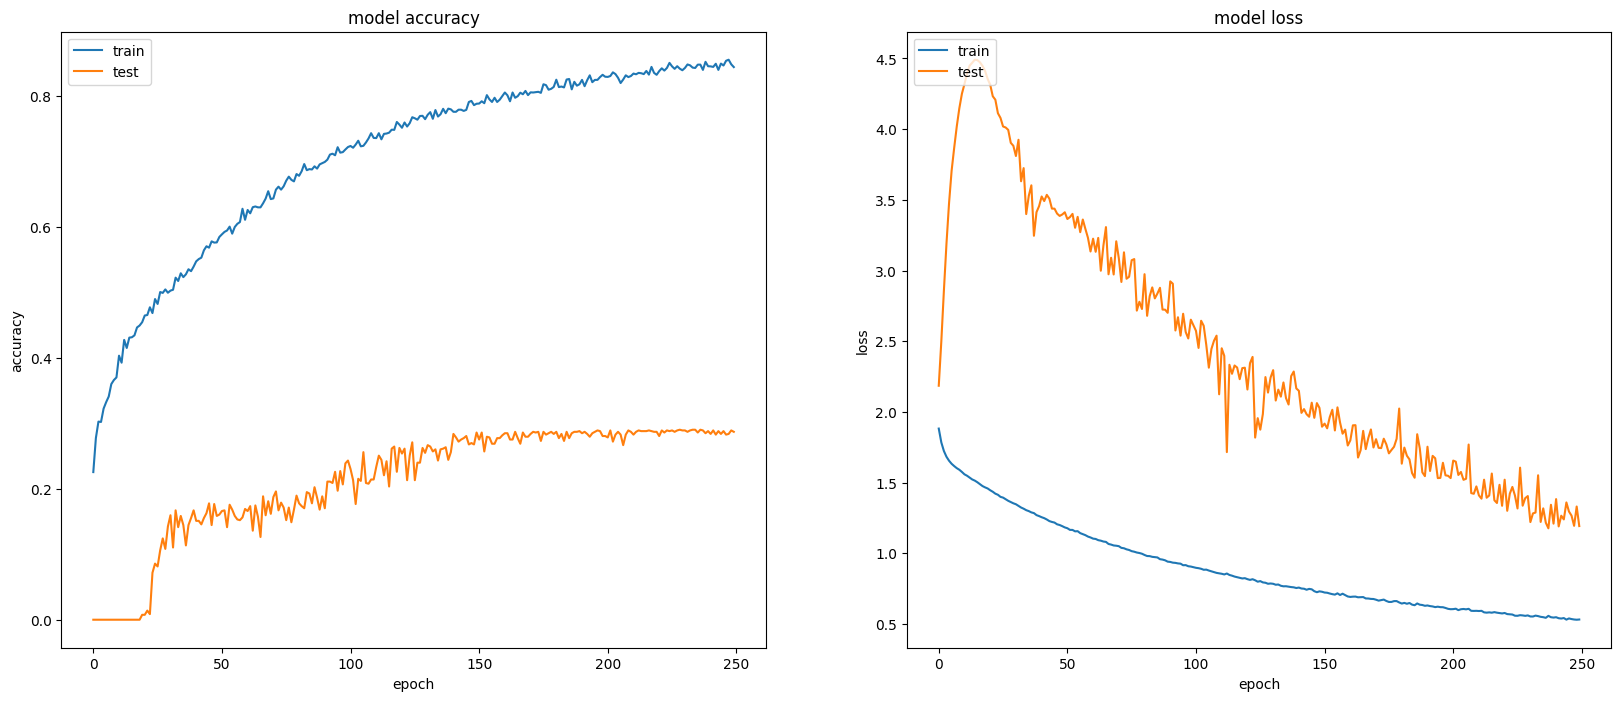

In [21]:
layers = [(10000,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### activation function tests

37/37 [==============================] - 0s 542us/step - loss: 1.7787 - accuracy: 0.3328


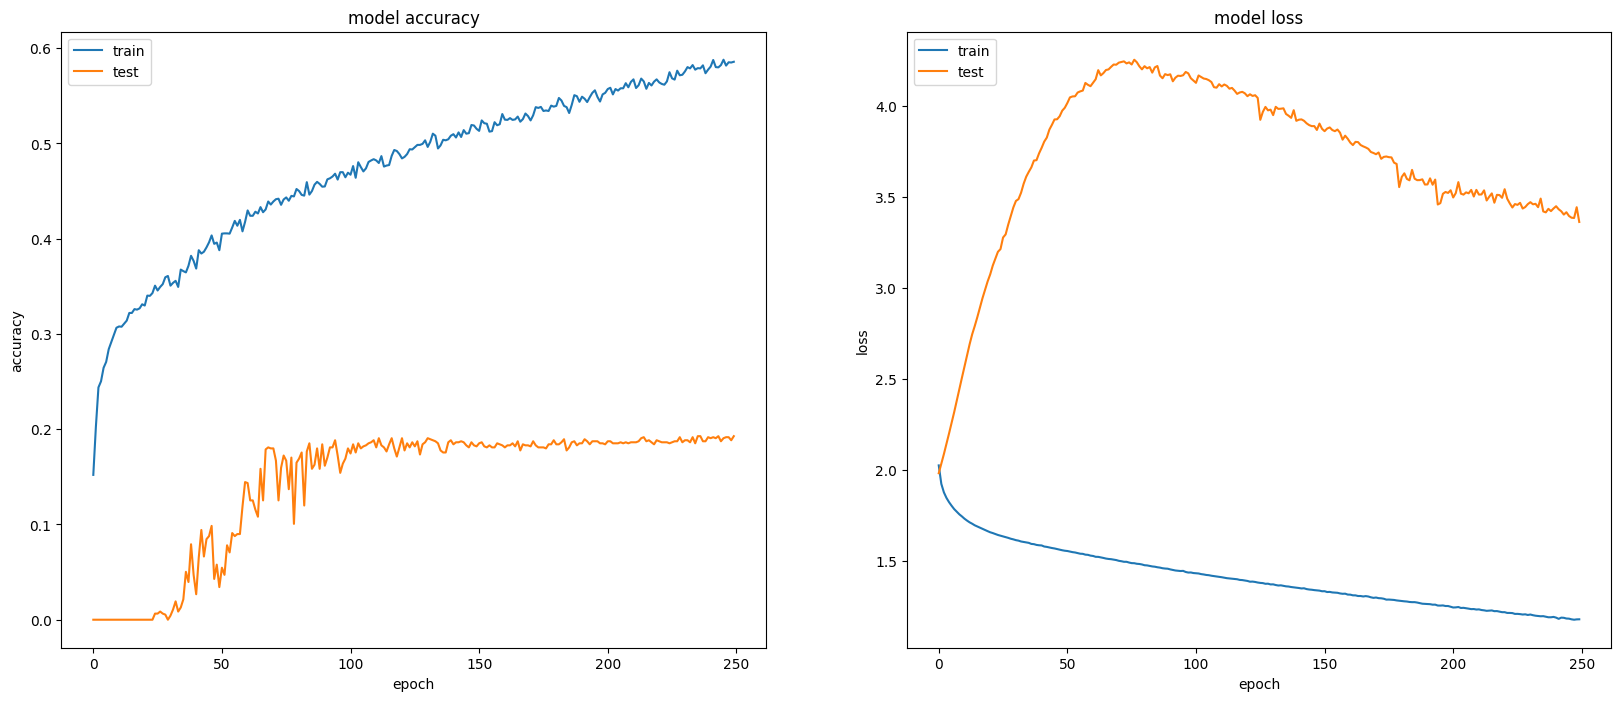

In [22]:
layers = [(500,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 547us/step - loss: 2.3705 - accuracy: 0.1925


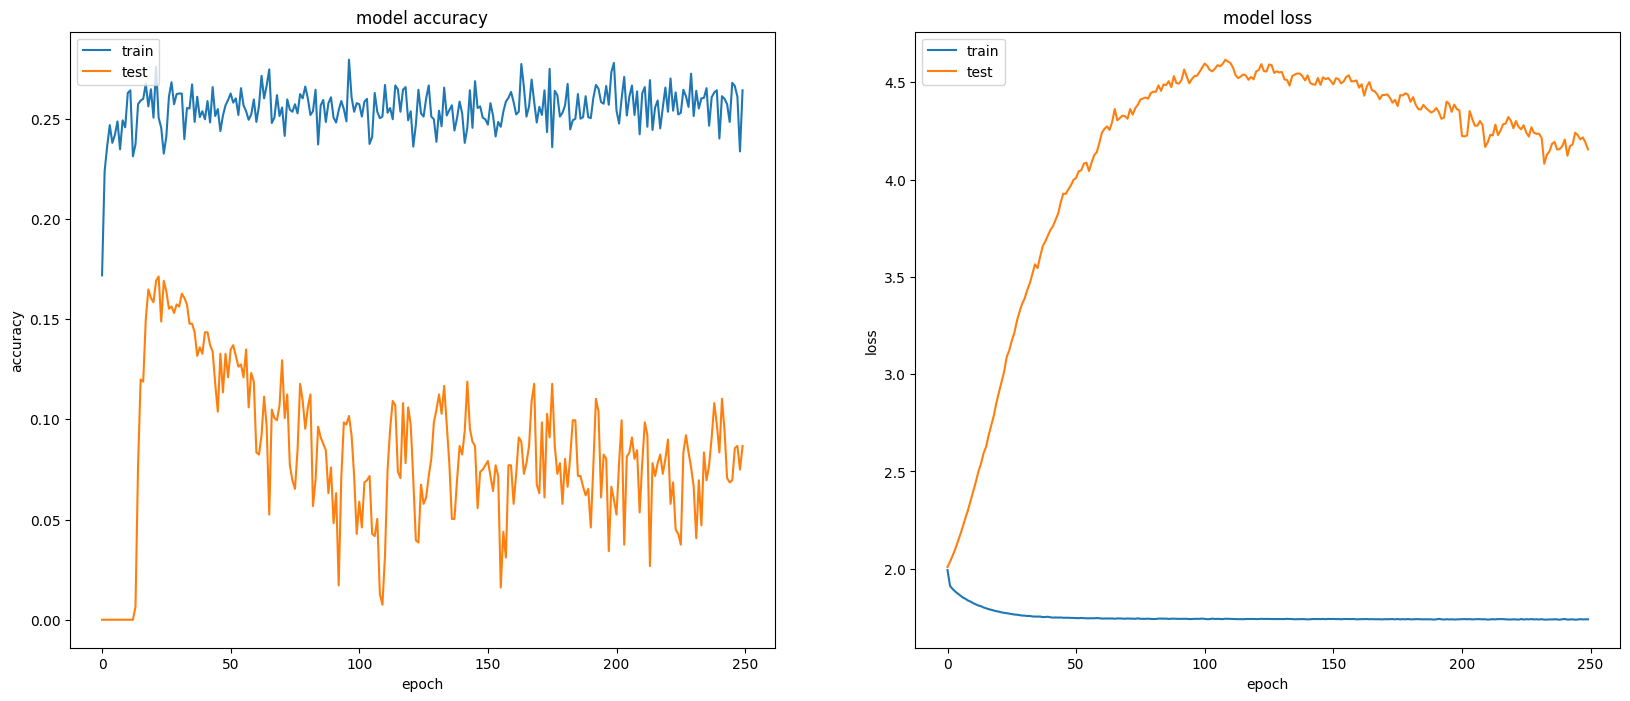

In [23]:
layers = [(500,"tanh")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 552us/step - loss: 2.4158 - accuracy: 0.2053


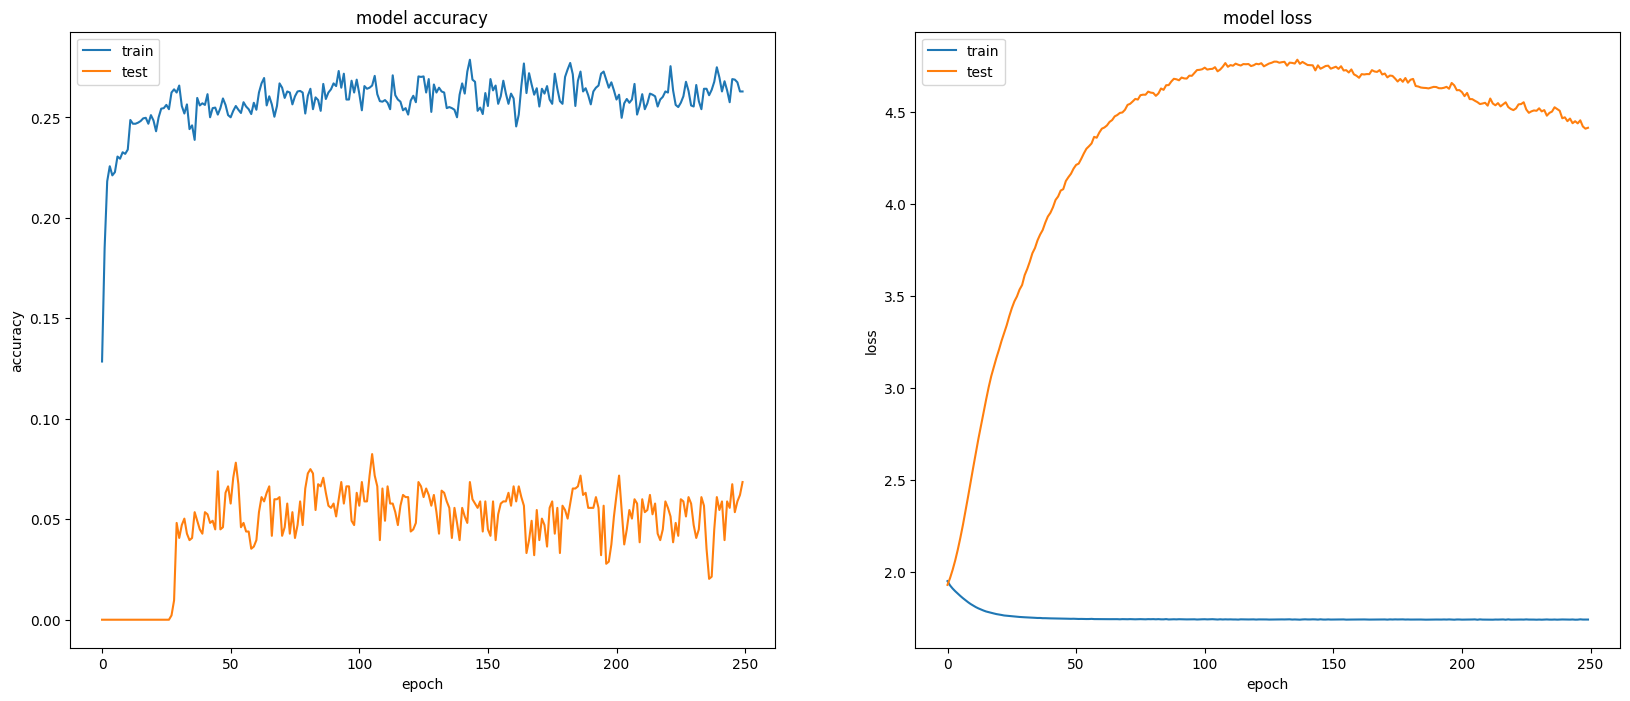

In [24]:
layers = [(500,"sigmoid")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### more layer (random)

##### with relu

37/37 [==============================] - 0s 586us/step - loss: 1.1936 - accuracy: 0.4482


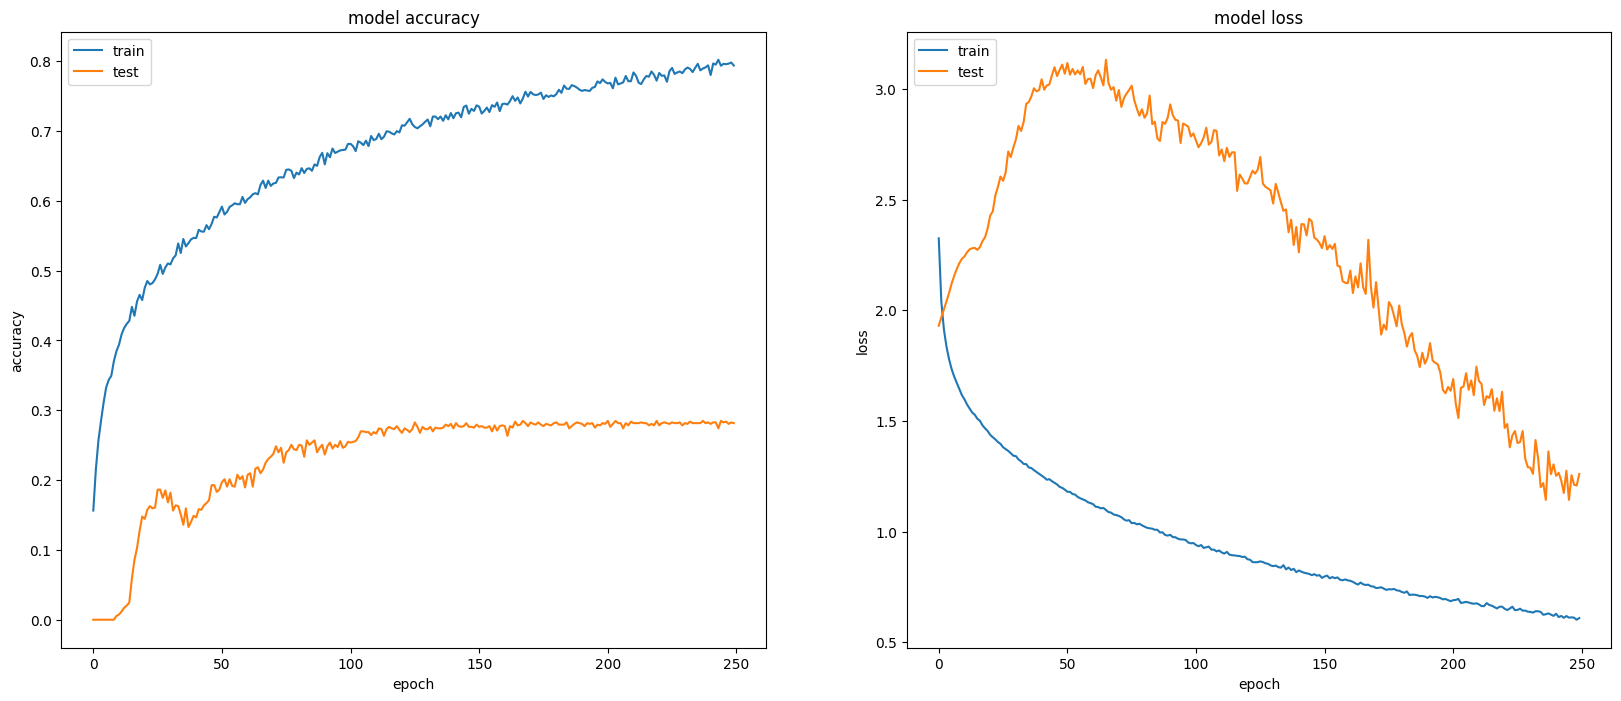

In [25]:
layers = [(100,"relu"), (200,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 906us/step - loss: 1.1856 - accuracy: 0.6621


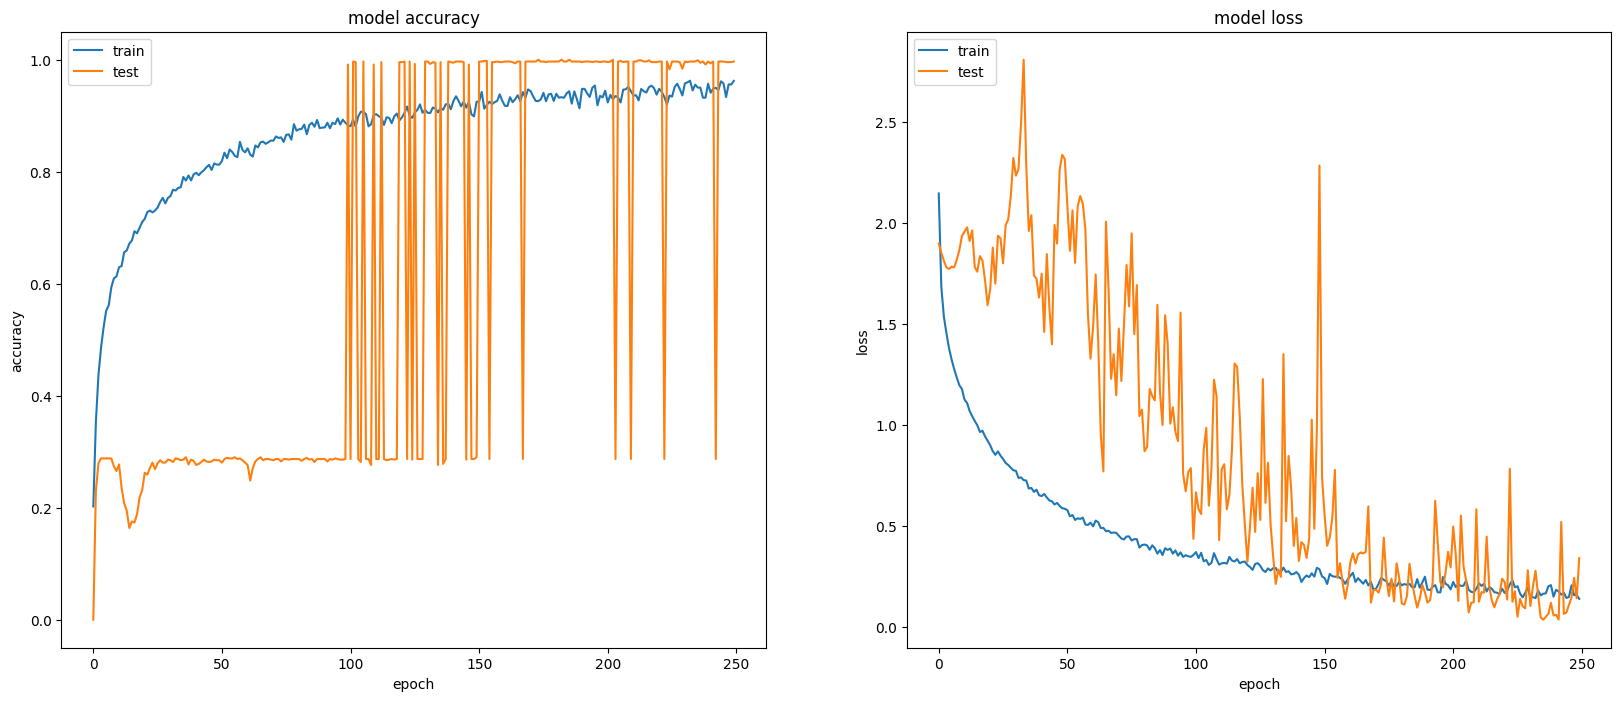

In [26]:
layers = [(500,"relu"), (300,"relu"), (100,"relu"), (50,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### with tanh

37/37 [==============================] - 0s 582us/step - loss: 1.2421 - accuracy: 0.5423


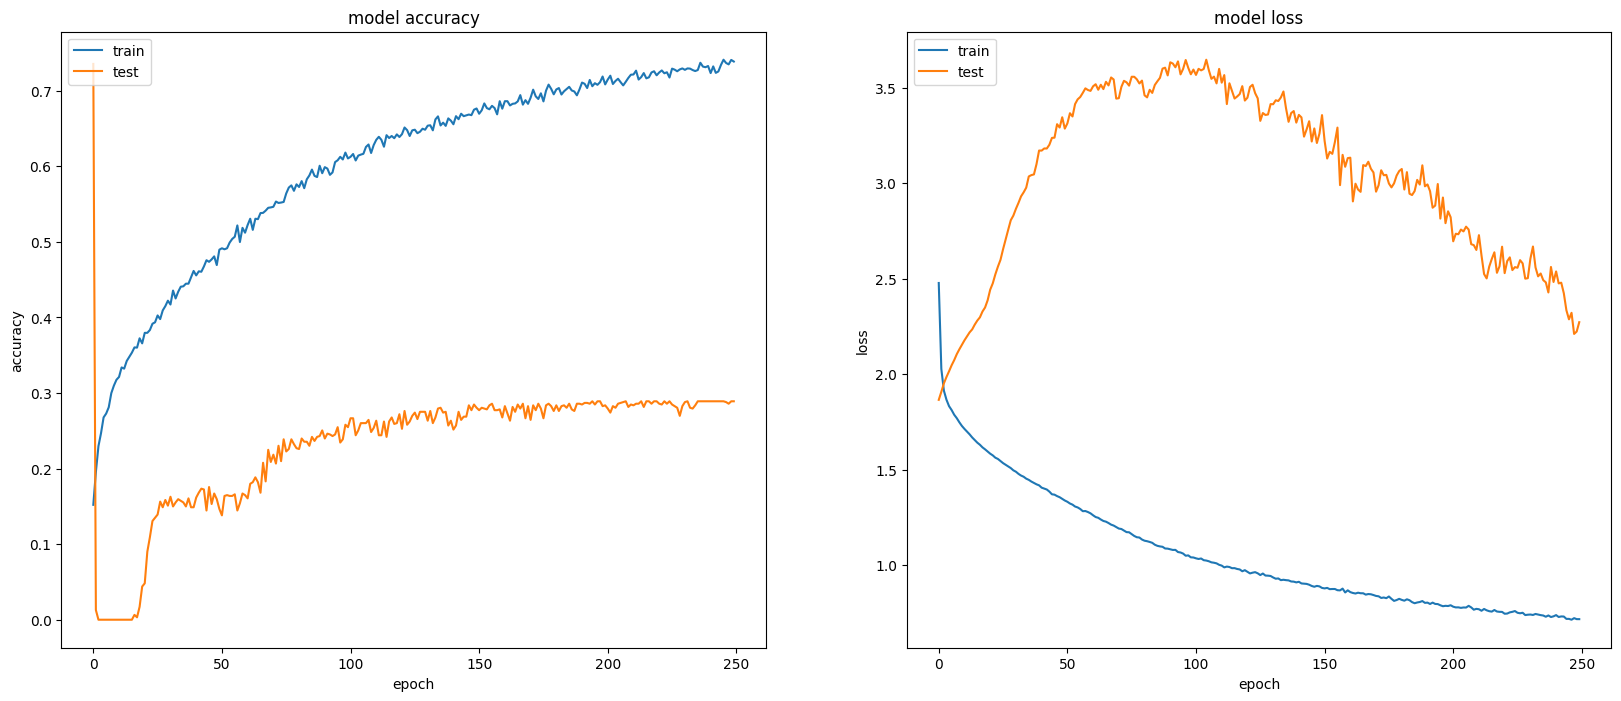

In [27]:
layers = [(100,"relu"), (200,"tanh")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 897us/step - loss: 1.1871 - accuracy: 0.6741


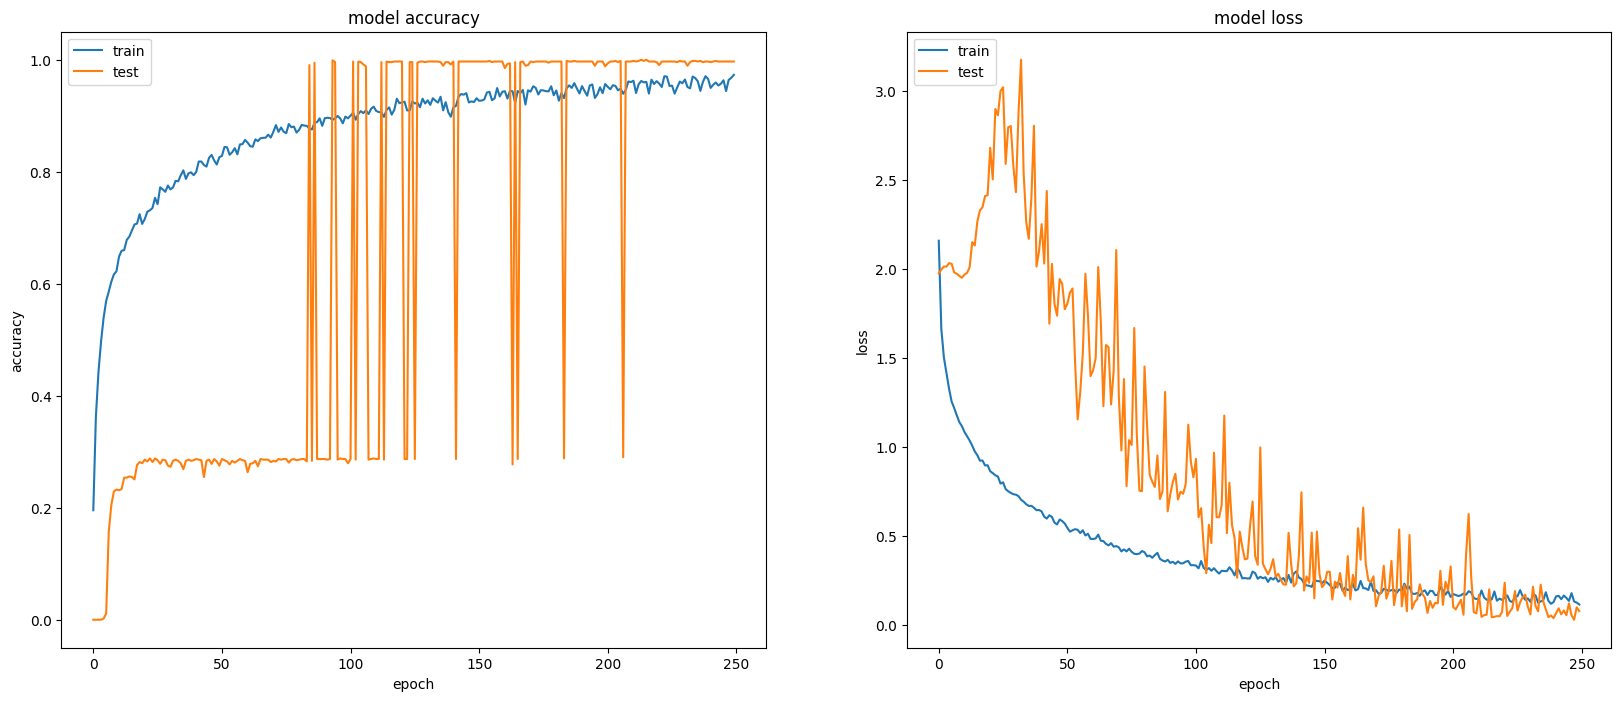

In [28]:
layers = [(500,"relu"), (300,"relu"), (100,"tanh"), (50,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

##### with sigmoid

37/37 [==============================] - 0s 580us/step - loss: 1.1578 - accuracy: 0.4953


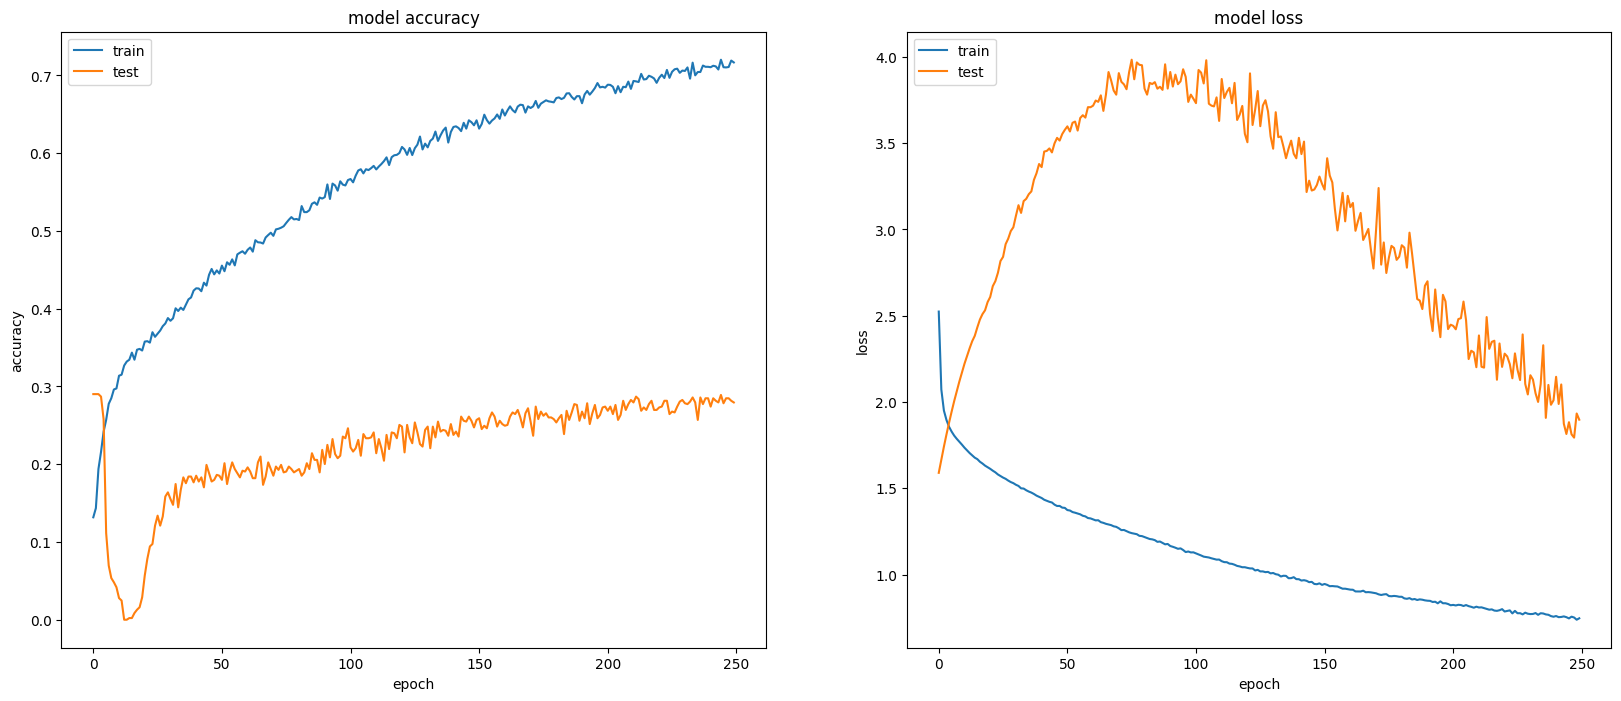

In [29]:
layers = [(100,"relu"), (200,"sigmoid")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 930us/step - loss: 1.0993 - accuracy: 0.6758


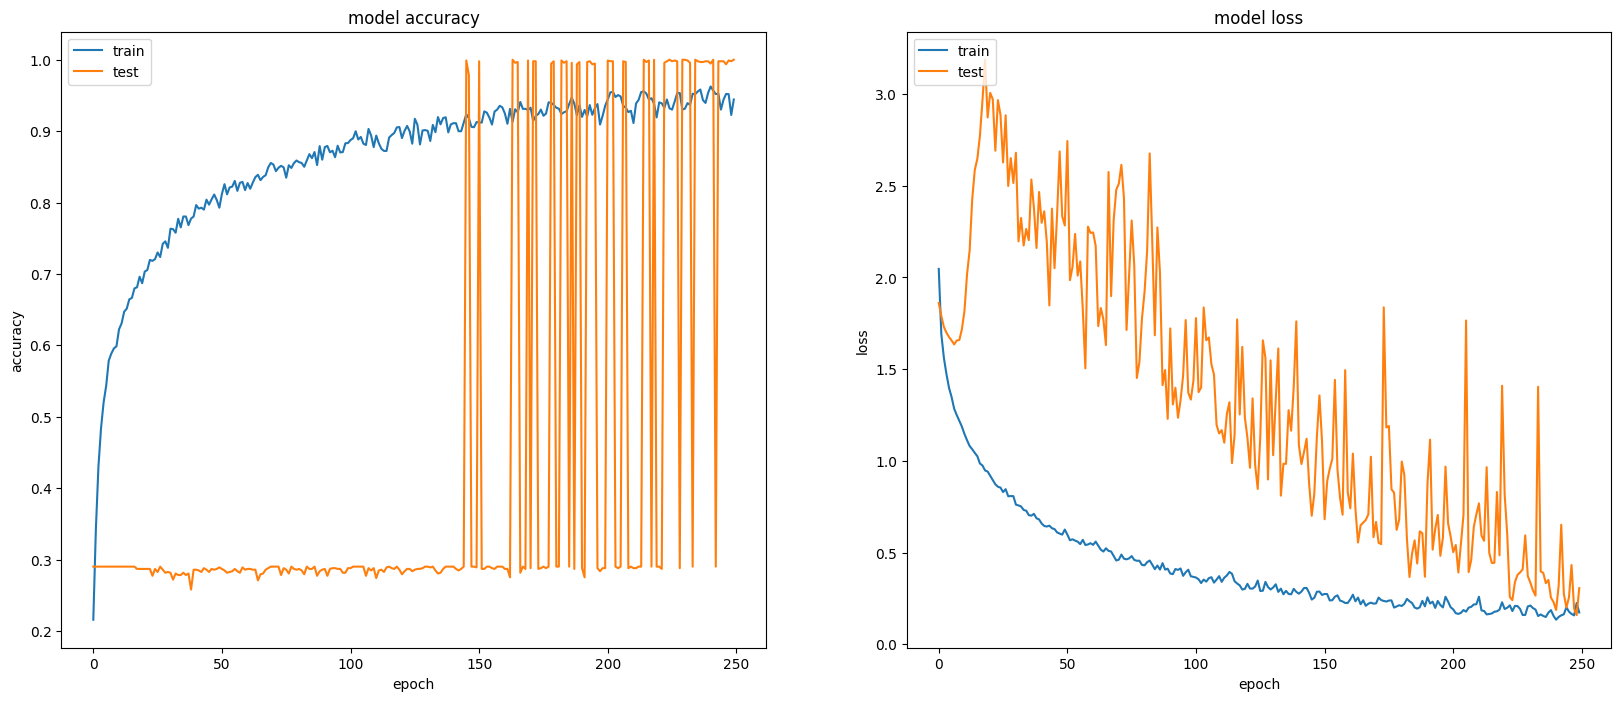

In [30]:
layers = [(500,"relu"), (300,"relu"), (100,"sigmoid"), (50,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

#### same layer like before with random fix dropout

37/37 [==============================] - 0s 589us/step - loss: 1.0290 - accuracy: 0.5244


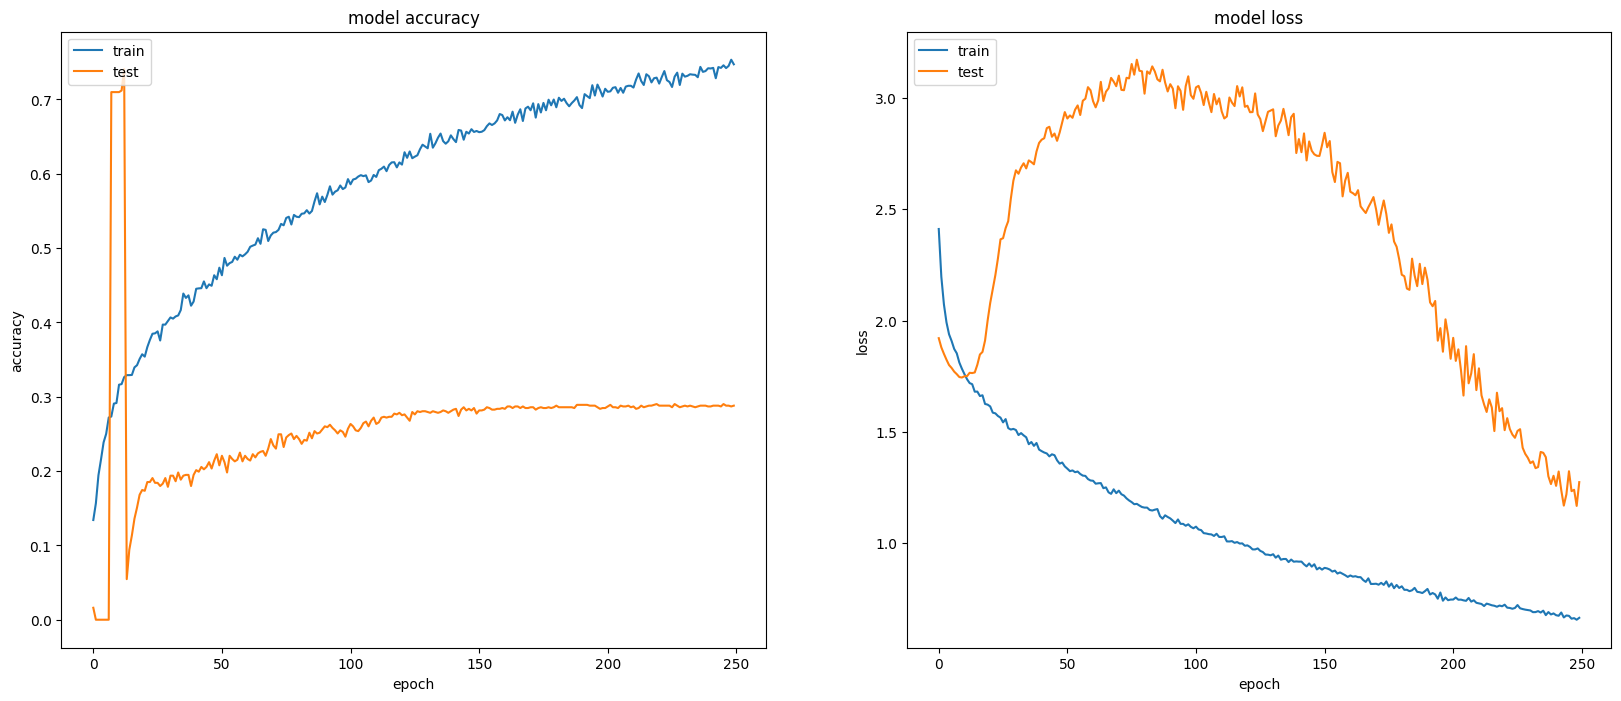

In [31]:
layers = [(100,"relu"), (200,"relu", 0.2)]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 889us/step - loss: 0.6413 - accuracy: 0.7776


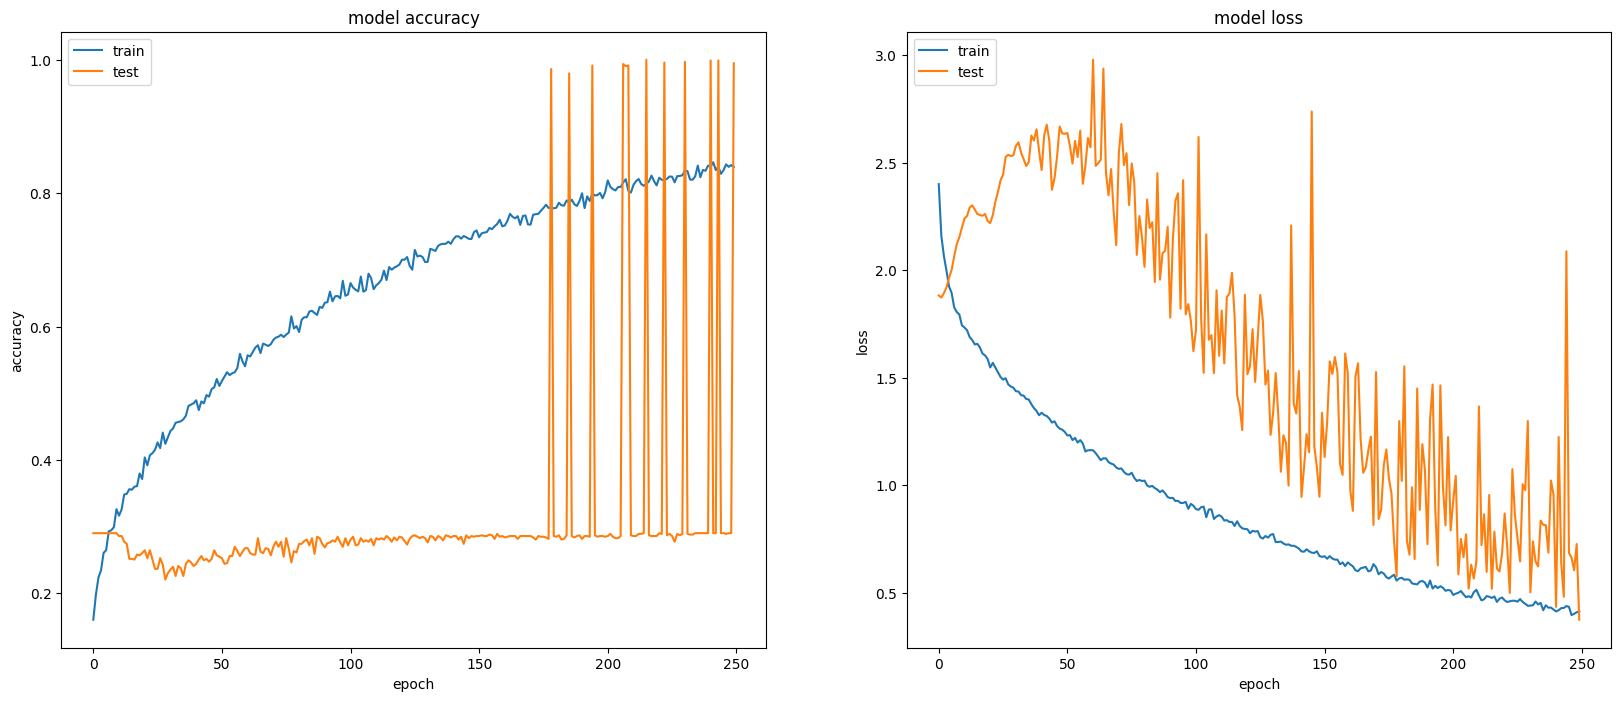

In [32]:
layers = [(500,"relu"), (300,"relu", 0.3), (100,"relu", 0.25), (50,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 545us/step - loss: 1.2873 - accuracy: 0.4679


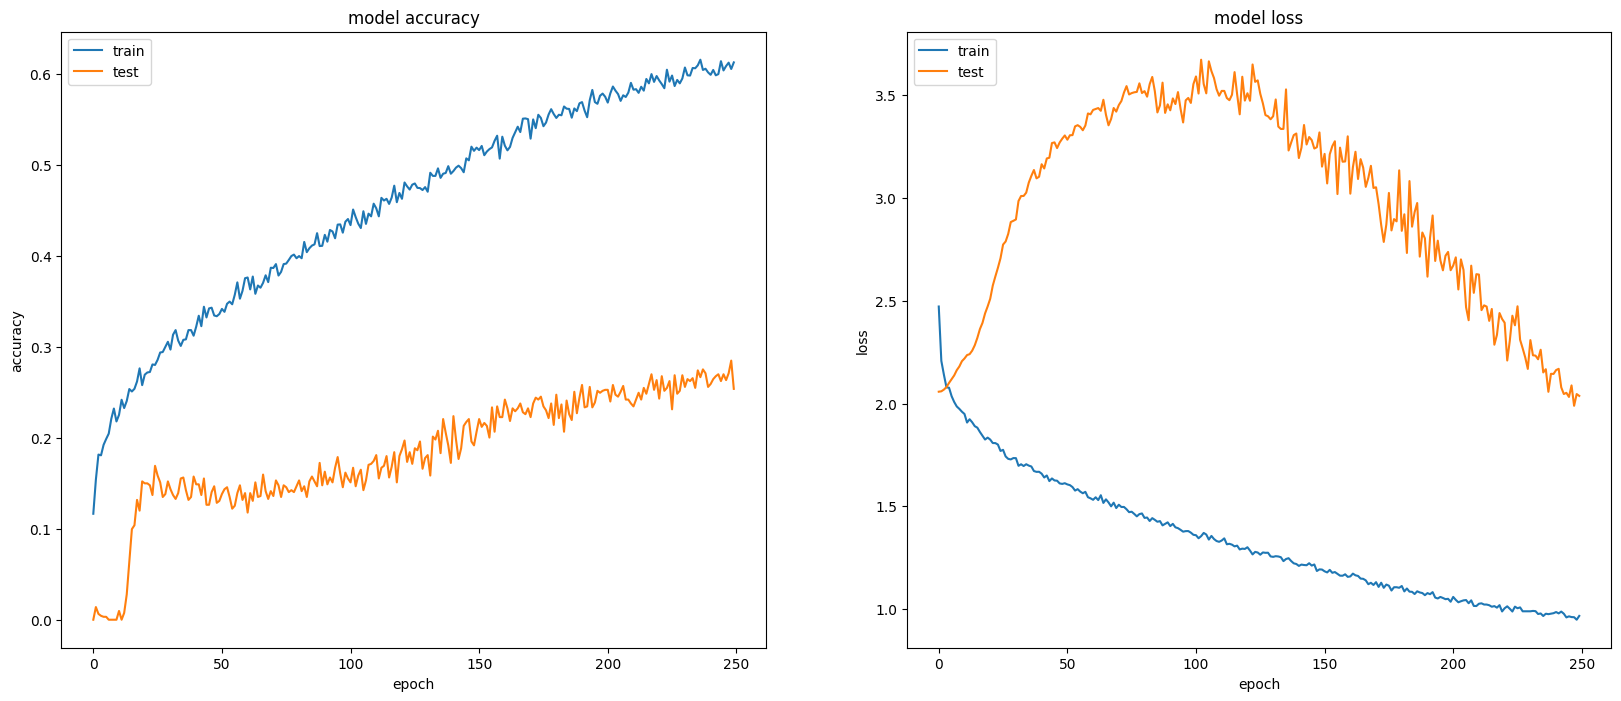

In [33]:
layers = [(100,"relu"), (200,"tanh", 0.2)]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 890us/step - loss: 0.9557 - accuracy: 0.6228


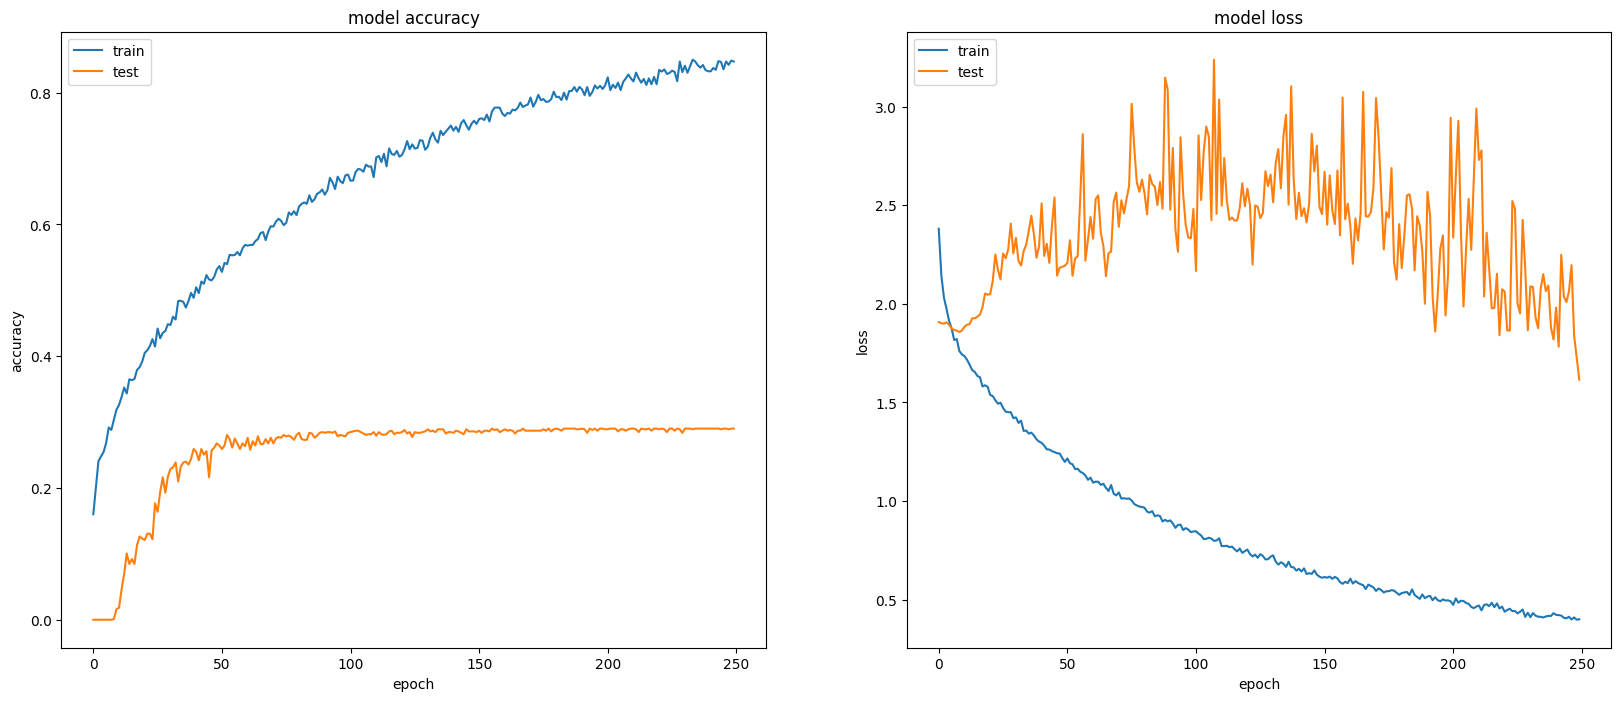

In [34]:
layers = [(500,"relu"), (300,"relu", 0.3), (100,"tanh", 0.25), (50,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 600us/step - loss: 1.5448 - accuracy: 0.4209


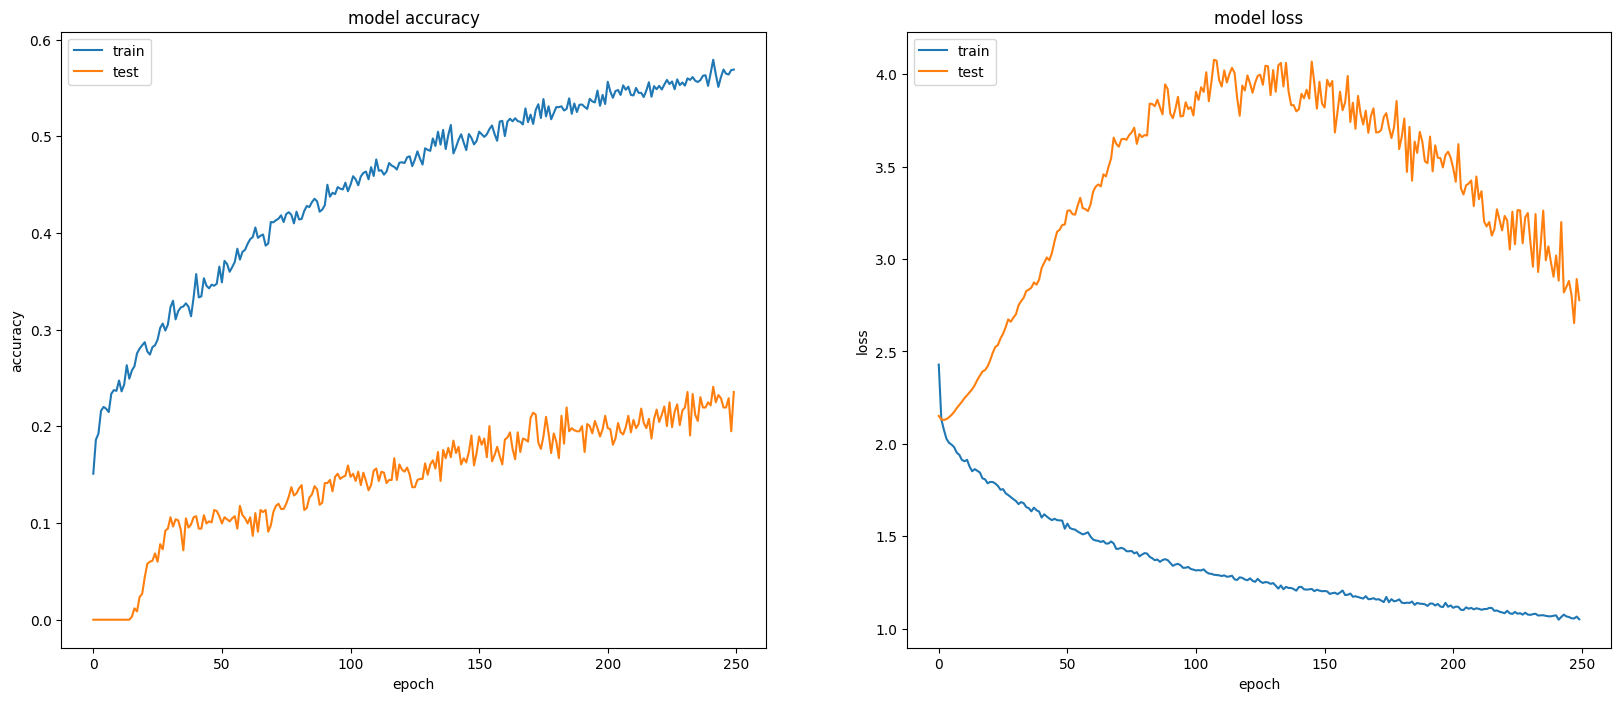

In [35]:
layers = [(100,"relu"), (200,"sigmoid", 0.2)]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 916us/step - loss: 0.7184 - accuracy: 0.6305


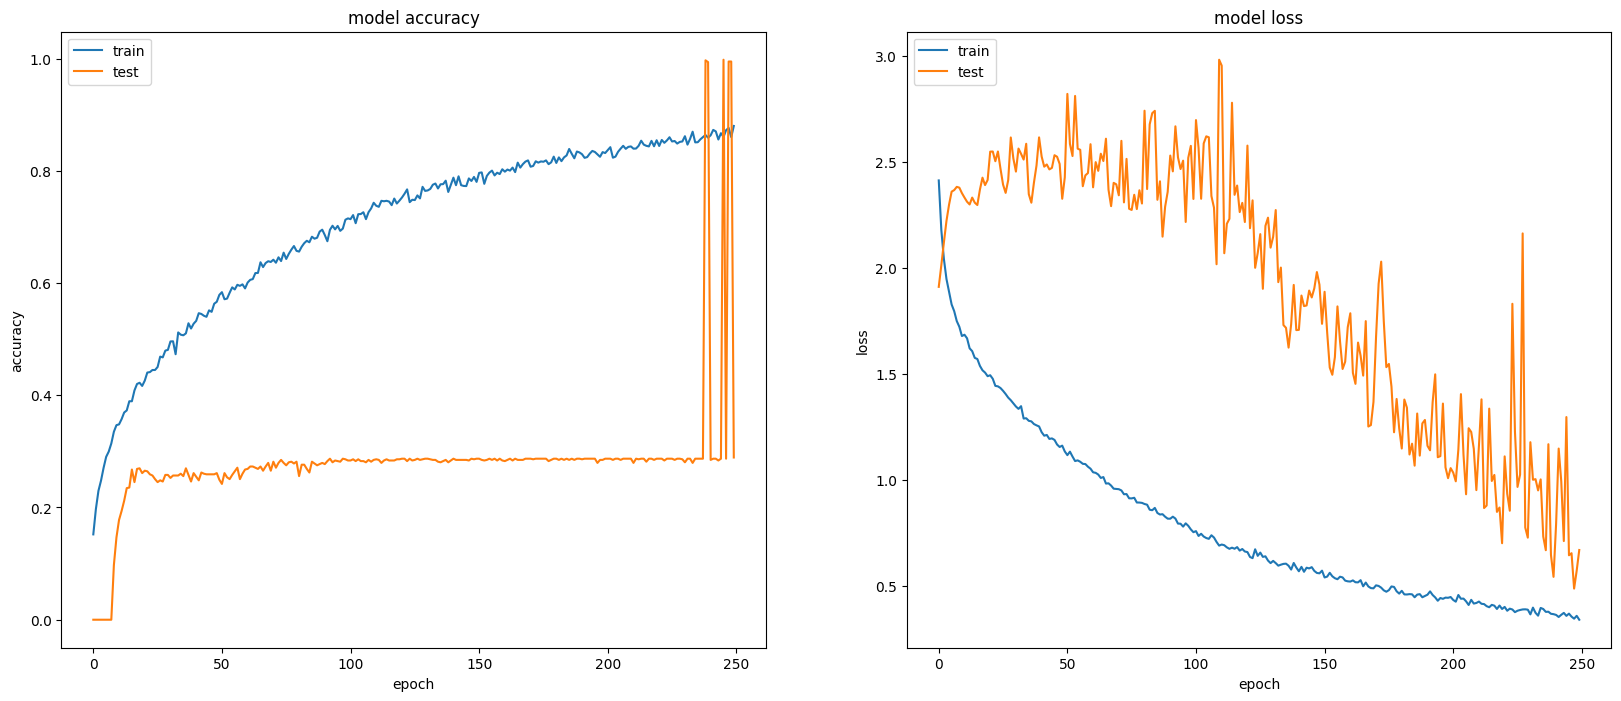

In [36]:
layers = [(500,"relu"), (300,"relu", 0.3), (100,"sigmoid", 0.25), (50,"relu")]
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, withHistory=1)
plot_acc_loss(history)

In [37]:
models

[{'layers': [(10, 'relu')],
  'optimizer': 'adam',
  'batchSize': 128,
  'learningRate': 0.0001,
  'epochs': 250,
  'endActi': 'softmax',
  'best_loss': 2.179574489593506,
  'best_accuracy': 0.16937553882598877,
  'loss': [2.272144079208374,
   2.258209228515625,
   2.242358922958374,
   2.228912591934204,
   2.215493679046631,
   2.2053399085998535,
   2.1930034160614014,
   2.1756515502929688,
   2.1659700870513916,
   2.153296709060669,
   2.142353057861328,
   2.12876296043396,
   2.1152048110961914,
   2.1025373935699463,
   2.093405246734619,
   2.0824193954467773,
   2.071336030960083,
   2.0650033950805664,
   2.0568649768829346,
   2.0516152381896973,
   2.042874813079834,
   2.0379698276519775,
   2.029496908187866,
   2.024998188018799,
   2.0200207233428955,
   2.013519763946533,
   2.0103795528411865,
   2.005042791366577,
   1.999859094619751,
   1.9948283433914185,
   1.9930217266082764,
   1.986697793006897,
   1.9823869466781616,
   1.9793285131454468,
   1.97667968273

In [38]:
def get_best_acc_model(models):
    bestItem = max(models, key=lambda x:x['best_accuracy'])
    return bestItem
def get_best_loss_model(models):
    bestItem = min(models, key=lambda x:x['best_loss'])
    return bestItem

## Get the best Model by loss

In [39]:
best_model = get_best_loss_model(models)
best_model

{'layers': [(500, 'relu'),
  (300, 'relu', 0.3),
  (100, 'relu', 0.25),
  (50, 'relu')],
 'optimizer': 'adam',
 'batchSize': 128,
 'learningRate': 0.0001,
 'epochs': 250,
 'endActi': 'softmax',
 'best_loss': 0.641319215297699,
 'best_accuracy': 0.7775876522064209,
 'loss': [2.4004647731781006,
  2.1602392196655273,
  2.0664827823638916,
  1.9977760314941406,
  1.9247561693191528,
  1.894754409790039,
  1.827316403388977,
  1.8057763576507568,
  1.7942979335784912,
  1.7434773445129395,
  1.73372483253479,
  1.7209975719451904,
  1.689458966255188,
  1.6757454872131348,
  1.655257225036621,
  1.657630443572998,
  1.6410014629364014,
  1.6126612424850464,
  1.6039522886276245,
  1.5875309705734253,
  1.5479168891906738,
  1.5693912506103516,
  1.5473028421401978,
  1.5261934995651245,
  1.5039856433868408,
  1.4913710355758667,
  1.4979387521743774,
  1.4692447185516357,
  1.4594966173171997,
  1.4538613557815552,
  1.437264323234558,
  1.436079740524292,
  1.4191185235977173,
  1.416940

## Get the best Model by accuracy

In [40]:
best_model = get_best_acc_model(models)
models = []

best_model

{'layers': [(500, 'relu'),
  (300, 'relu', 0.3),
  (100, 'relu', 0.25),
  (50, 'relu')],
 'optimizer': 'adam',
 'batchSize': 128,
 'learningRate': 0.0001,
 'epochs': 250,
 'endActi': 'softmax',
 'best_loss': 0.641319215297699,
 'best_accuracy': 0.7775876522064209,
 'loss': [2.4004647731781006,
  2.1602392196655273,
  2.0664827823638916,
  1.9977760314941406,
  1.9247561693191528,
  1.894754409790039,
  1.827316403388977,
  1.8057763576507568,
  1.7942979335784912,
  1.7434773445129395,
  1.73372483253479,
  1.7209975719451904,
  1.689458966255188,
  1.6757454872131348,
  1.655257225036621,
  1.657630443572998,
  1.6410014629364014,
  1.6126612424850464,
  1.6039522886276245,
  1.5875309705734253,
  1.5479168891906738,
  1.5693912506103516,
  1.5473028421401978,
  1.5261934995651245,
  1.5039856433868408,
  1.4913710355758667,
  1.4979387521743774,
  1.4692447185516357,
  1.4594966173171997,
  1.4538613557815552,
  1.437264323234558,
  1.436079740524292,
  1.4191185235977173,
  1.416940

### Change the batchSize for the best model - one lower, one higher

37/37 [==============================] - 0s 916us/step - loss: 0.7854 - accuracy: 0.5971


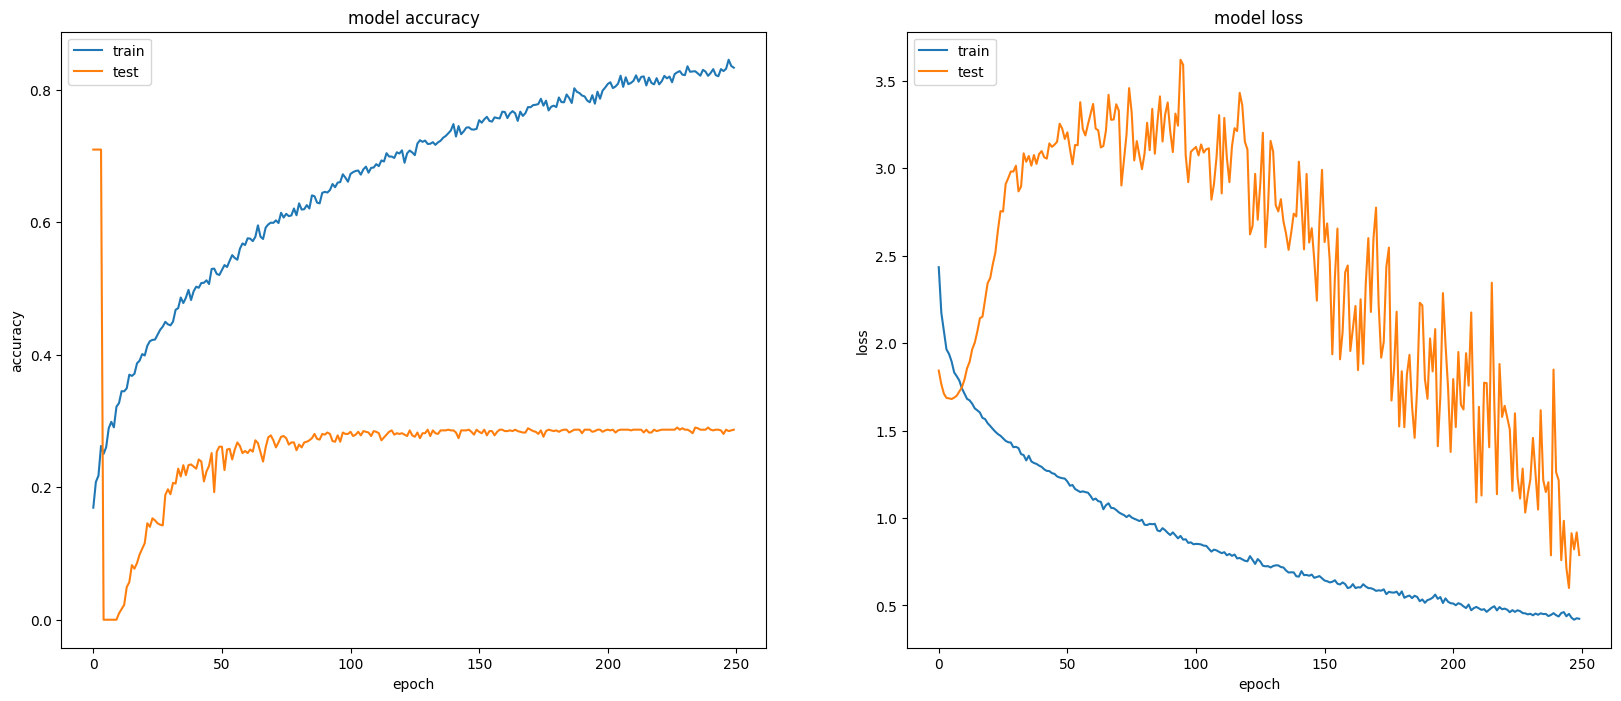

In [41]:
layers = best_model['layers'] ## best model from step before
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 870us/step - loss: 0.5685 - accuracy: 0.7861


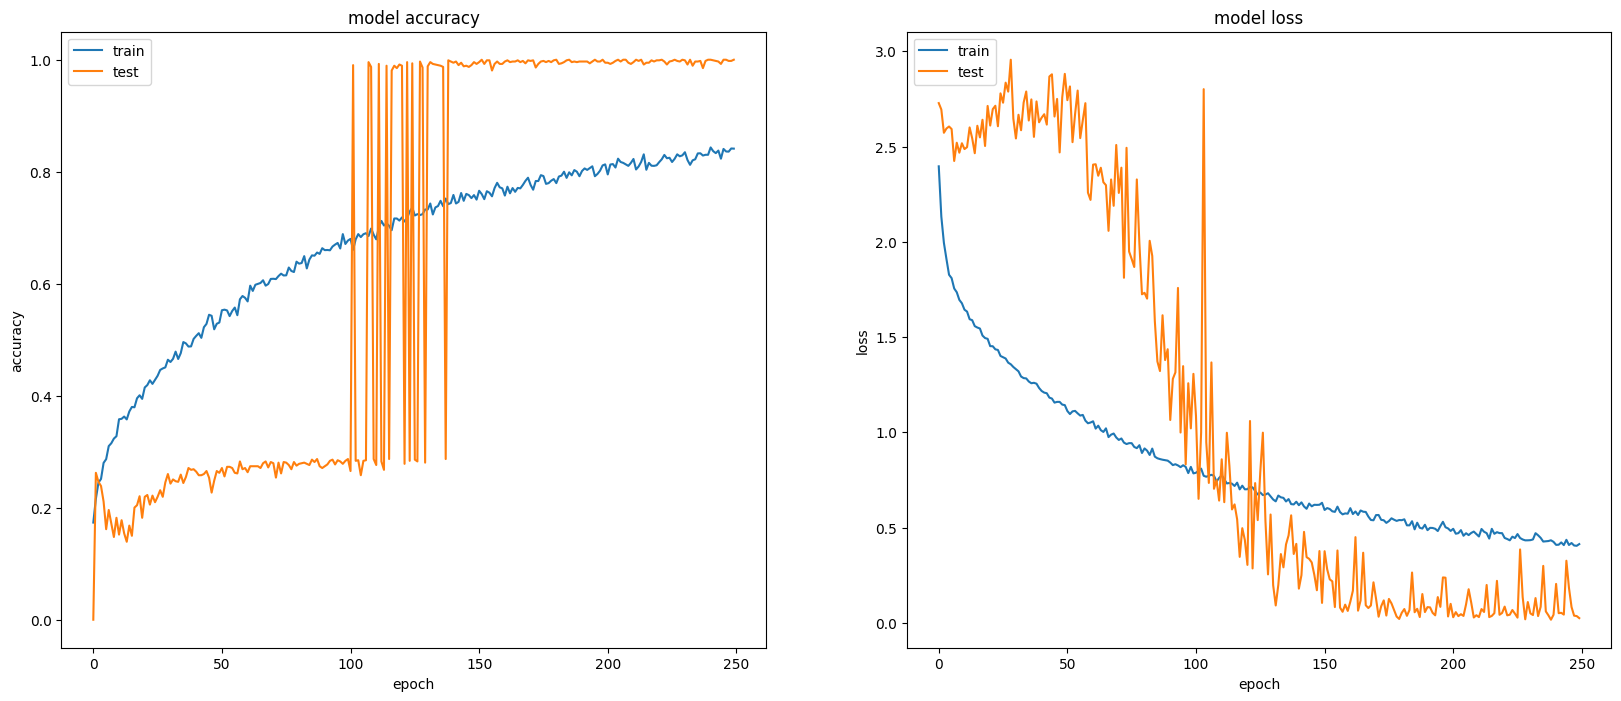

In [42]:
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, batchSize=32, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 892us/step - loss: 1.2650 - accuracy: 0.5064


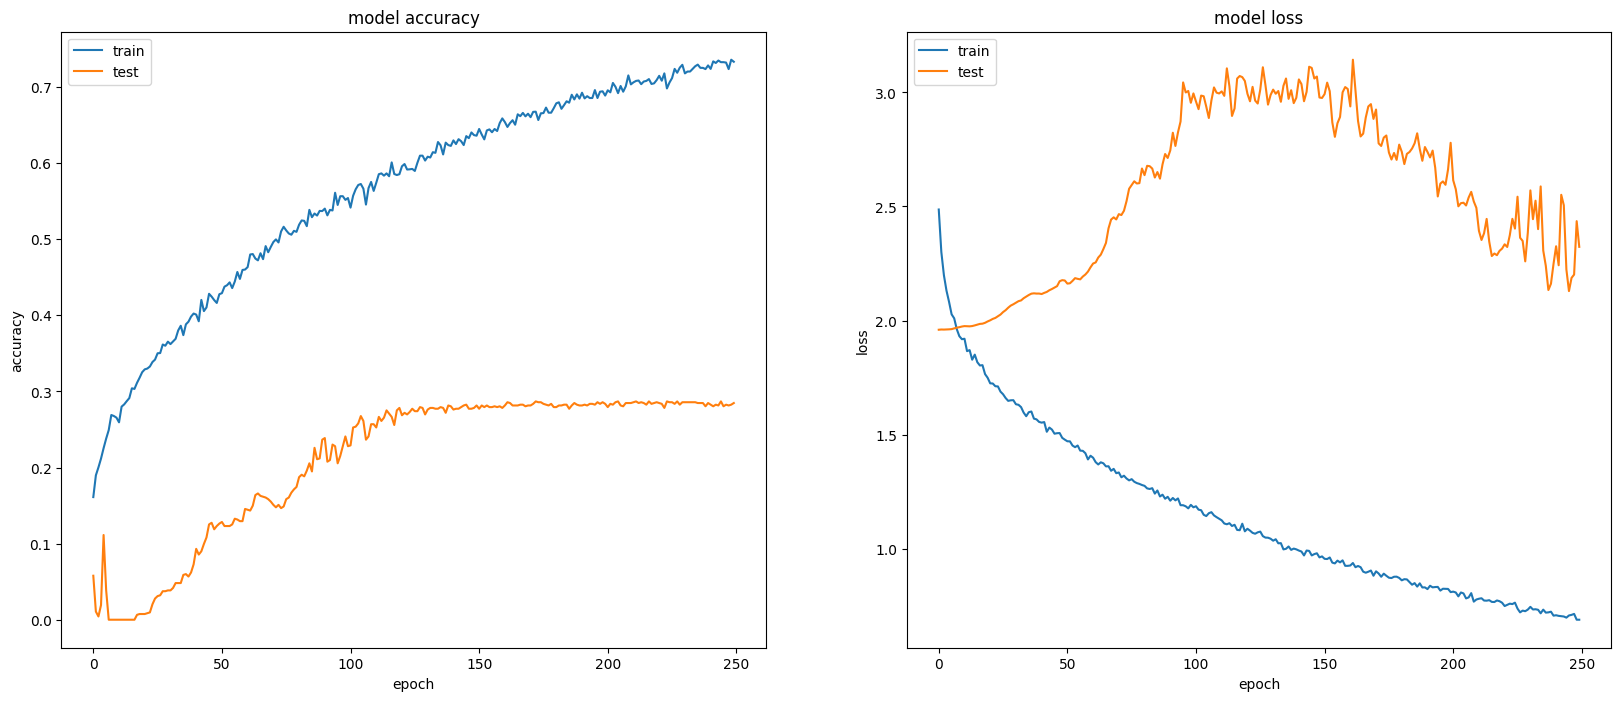

In [43]:
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, batchSize=512, withHistory=1)
plot_acc_loss(history)

### Create the best model again and find now the best optimizer for this model
We create everytime the model new for the performance. Otherwise we must save every model and this don´t like our computer.

In [44]:
best_model = get_best_acc_model(models)
models = []

best_model

{'layers': [(500, 'relu'),
  (300, 'relu', 0.3),
  (100, 'relu', 0.25),
  (50, 'relu')],
 'optimizer': 'adam',
 'batchSize': 32,
 'learningRate': 0.0001,
 'epochs': 250,
 'endActi': 'softmax',
 'best_loss': 0.568506121635437,
 'best_accuracy': 0.7861419916152954,
 'loss': [2.3962788581848145,
  2.132296562194824,
  1.994636058807373,
  1.9090230464935303,
  1.8272628784179688,
  1.809424638748169,
  1.7553006410598755,
  1.735404372215271,
  1.6954666376113892,
  1.6776014566421509,
  1.643989086151123,
  1.6338672637939453,
  1.5938831567764282,
  1.5888714790344238,
  1.5575661659240723,
  1.5502727031707764,
  1.5450572967529297,
  1.5081576108932495,
  1.4950592517852783,
  1.4909353256225586,
  1.4526113271713257,
  1.4521100521087646,
  1.4357966184616089,
  1.4325870275497437,
  1.4010899066925049,
  1.394171118736267,
  1.3877308368682861,
  1.3658090829849243,
  1.3574312925338745,
  1.3431053161621094,
  1.3313443660736084,
  1.3203359842300415,
  1.2931313514709473,
  1.2848

37/37 [==============================] - 0s 869us/step - loss: 0.5571 - accuracy: 0.7742


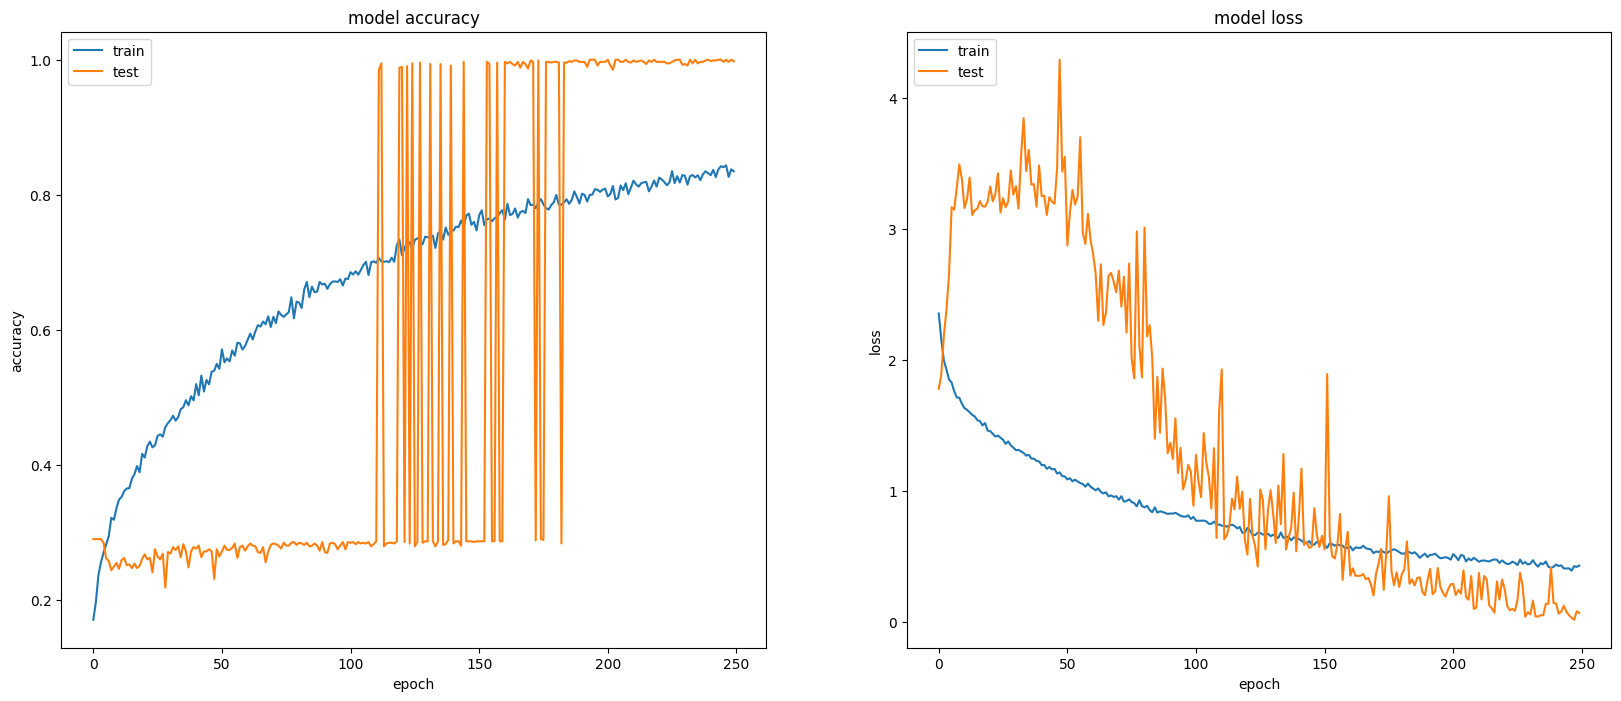

In [45]:
layers = best_model['layers'] ## best model from step before
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 875us/step - loss: 0.5275 - accuracy: 0.7998


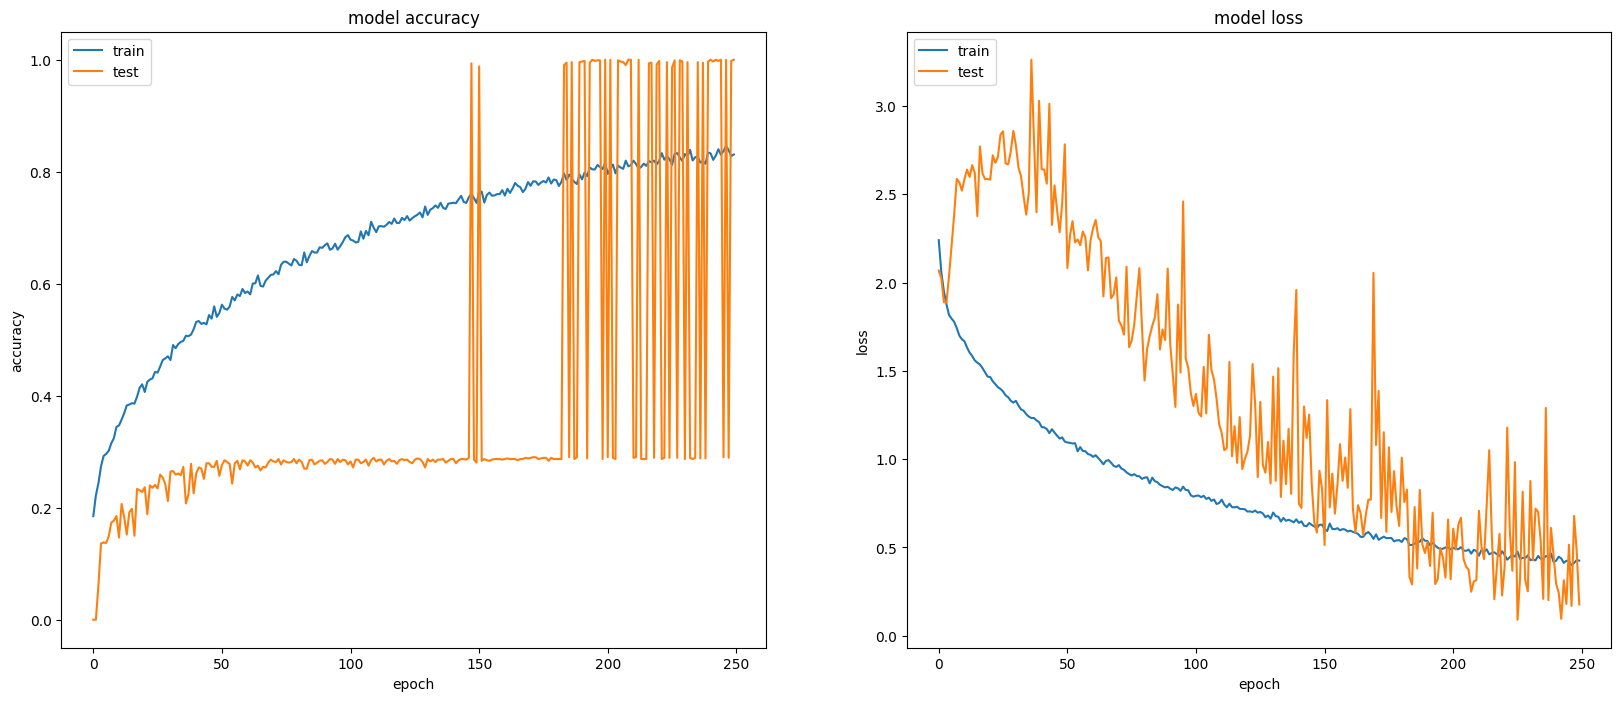

In [46]:
#Model with Nadam optimizer
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer='nadam', endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 893us/step - loss: 1.7879 - accuracy: 0.3208


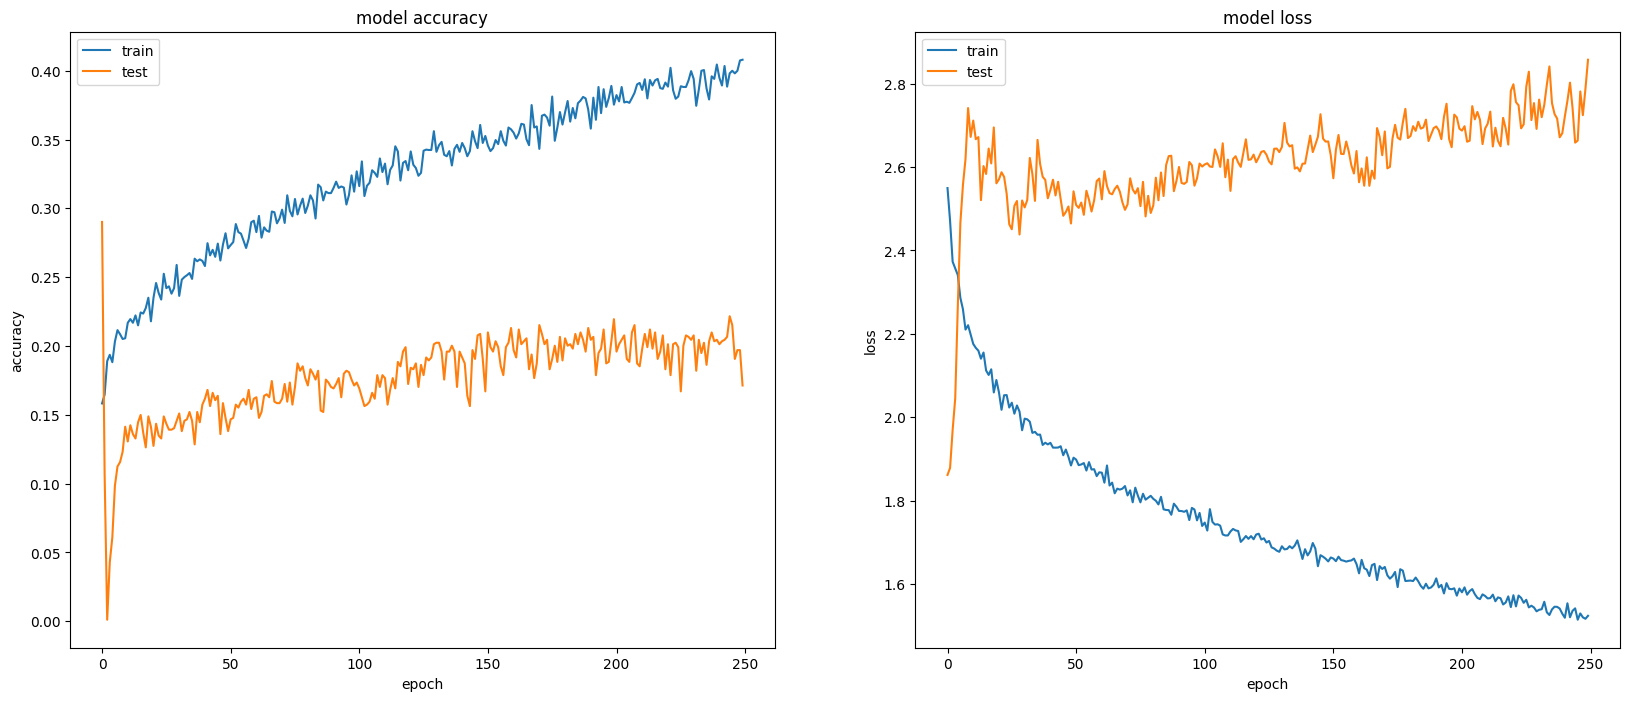

In [47]:
#Model with SGD optimizer
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer='sgd', endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 901us/step - loss: 2.1187 - accuracy: 0.2678


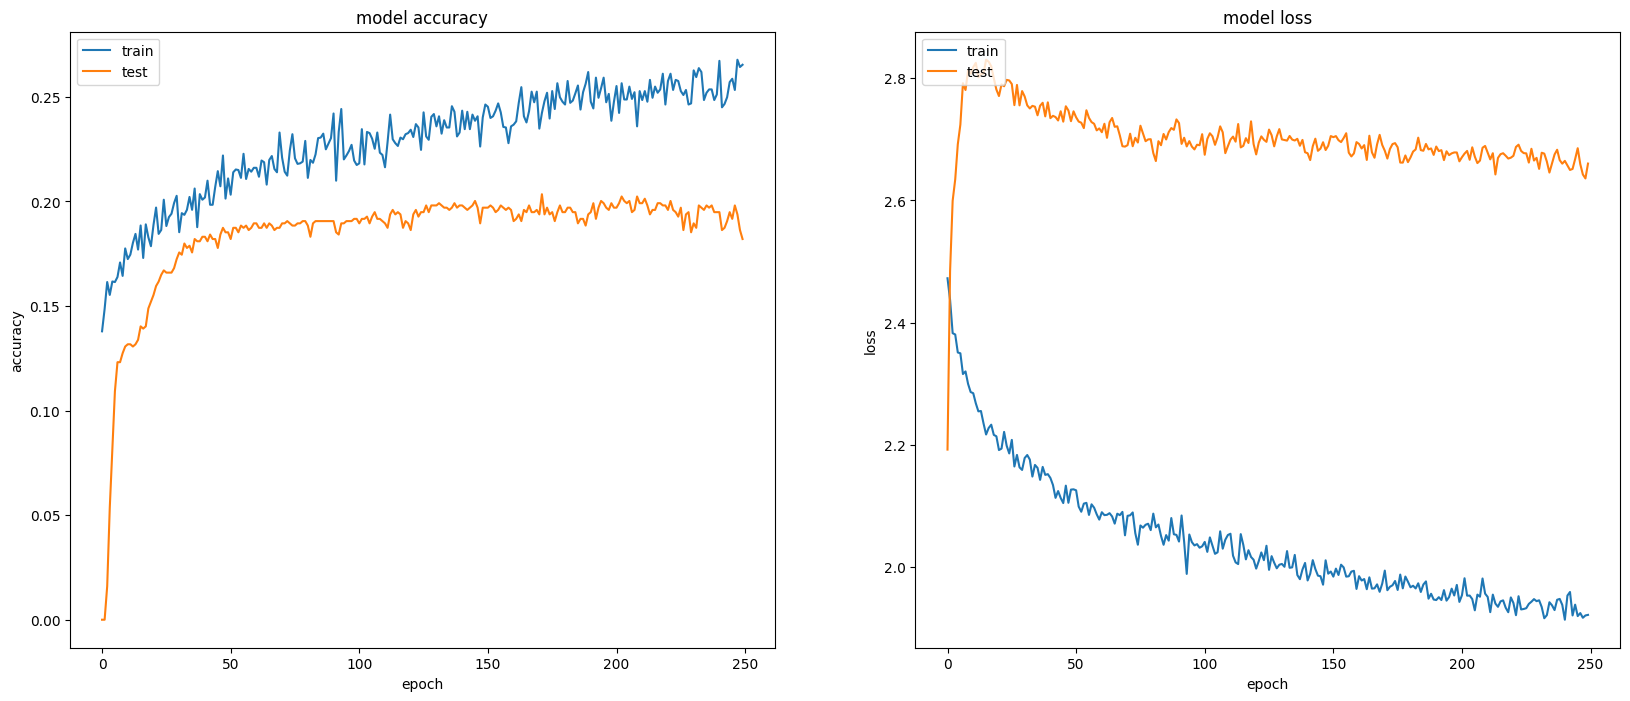

In [48]:
#Model with Adagrad optimizer
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer='adagrad', endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

### Change the learning rate for the best model

In [49]:
best_model = get_best_acc_model(models)
models = []

best_model

{'layers': [(500, 'relu'),
  (300, 'relu', 0.3),
  (100, 'relu', 0.25),
  (50, 'relu')],
 'optimizer': 'nadam',
 'batchSize': 32,
 'learningRate': 0.0001,
 'epochs': 250,
 'endActi': 'softmax',
 'best_loss': 0.5275093913078308,
 'best_accuracy': 0.7998288869857788,
 'loss': [2.240344762802124,
  2.0576305389404297,
  1.9503657817840576,
  1.8765692710876465,
  1.8158575296401978,
  1.7956044673919678,
  1.7777595520019531,
  1.7424064874649048,
  1.6997750997543335,
  1.6789964437484741,
  1.6674572229385376,
  1.6321443319320679,
  1.6029937267303467,
  1.584265112876892,
  1.5591131448745728,
  1.5464149713516235,
  1.5359913110733032,
  1.5158047676086426,
  1.491468906402588,
  1.4671947956085205,
  1.4653459787368774,
  1.4404090642929077,
  1.4246923923492432,
  1.4071189165115356,
  1.3978478908538818,
  1.3832848072052002,
  1.3607207536697388,
  1.3505253791809082,
  1.3305273056030273,
  1.3202321529388428,
  1.3300913572311401,
  1.3030481338500977,
  1.2815735340118408,
  1

37/37 [==============================] - 0s 891us/step - loss: 0.6496 - accuracy: 0.7305


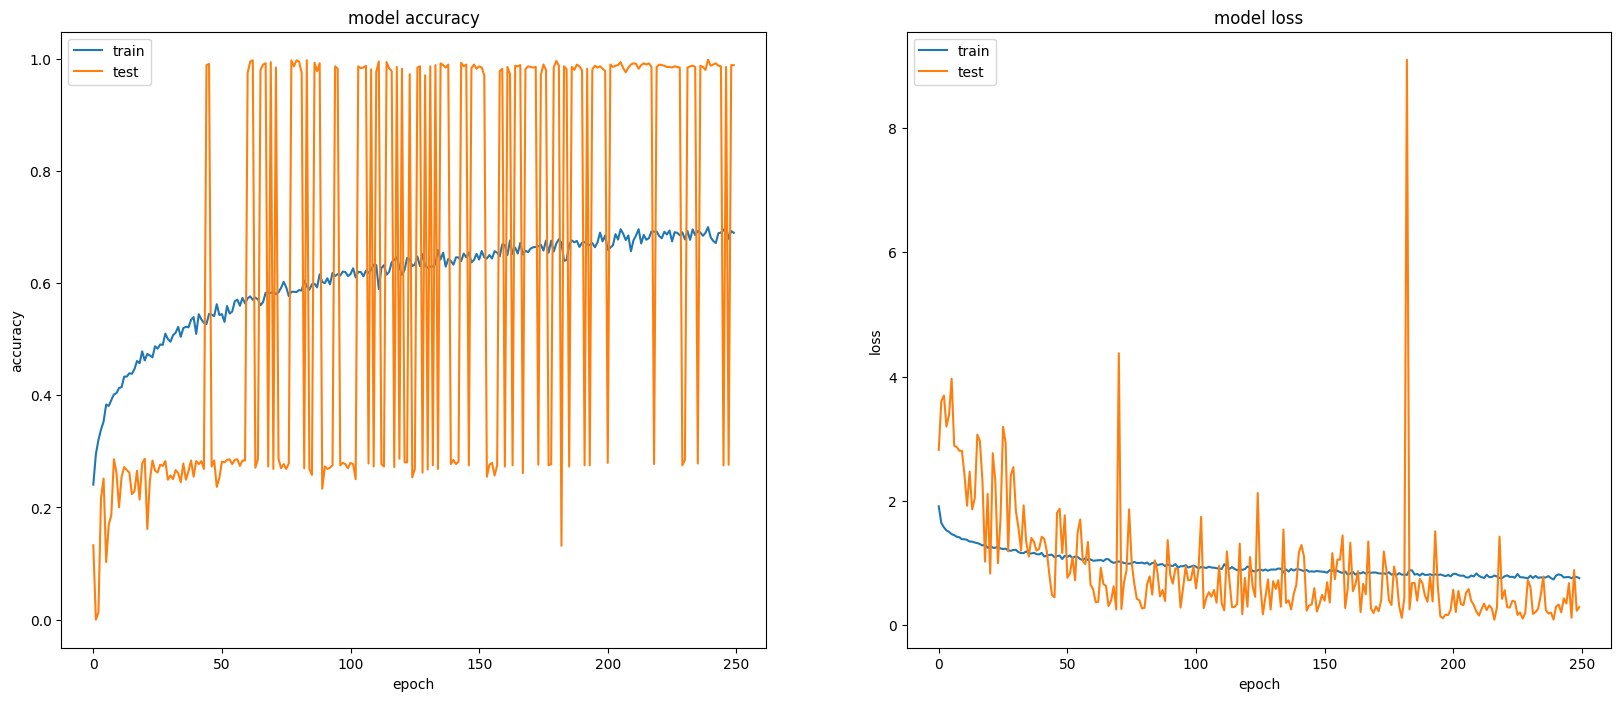

In [50]:
layers = best_model['layers'] ## best model from step before
learningRate=best_model['learningRate']*50
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=learningRate, batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 914us/step - loss: 0.4815 - accuracy: 0.8332


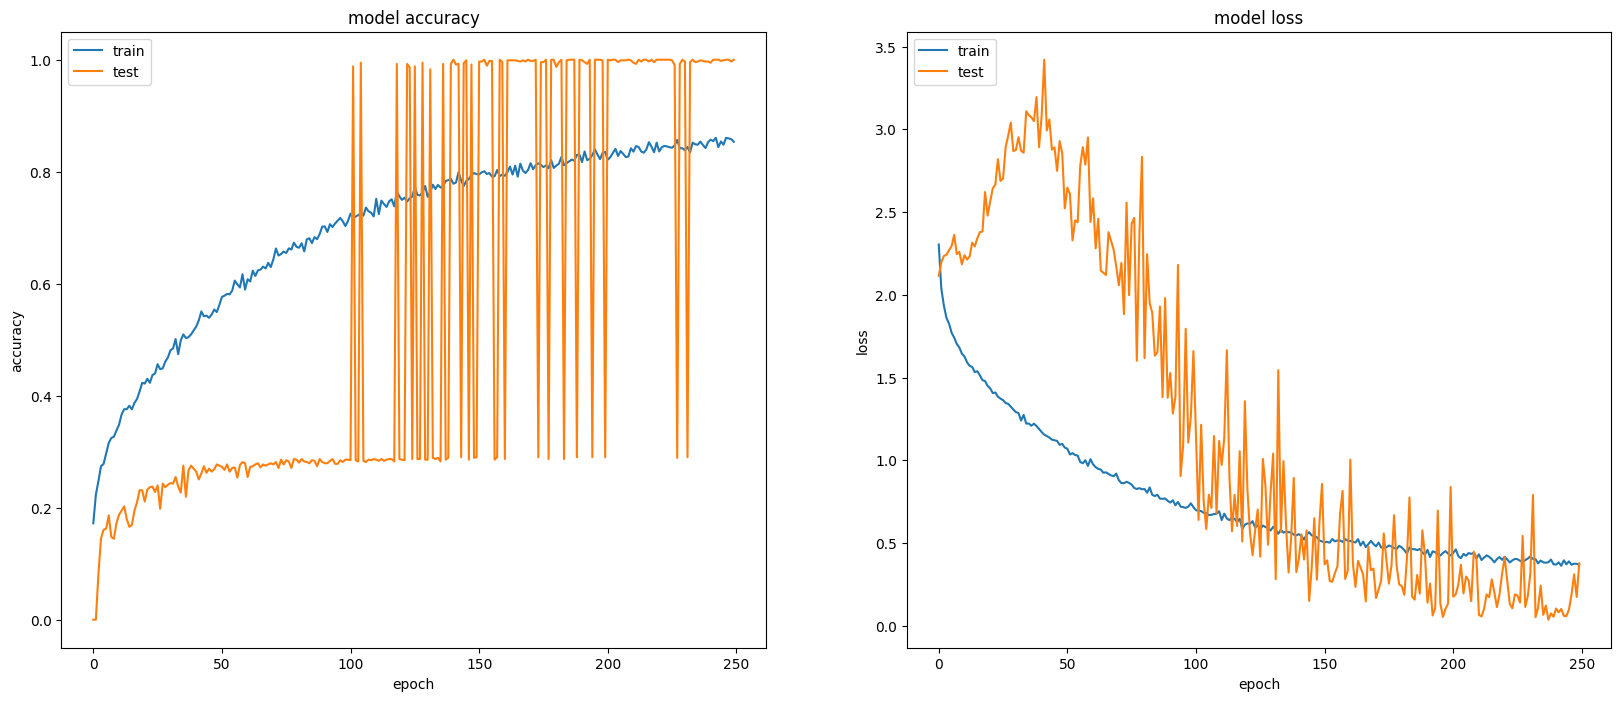

In [51]:
learningRate=best_model['learningRate']*100
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 902us/step - loss: 0.5272 - accuracy: 0.8075


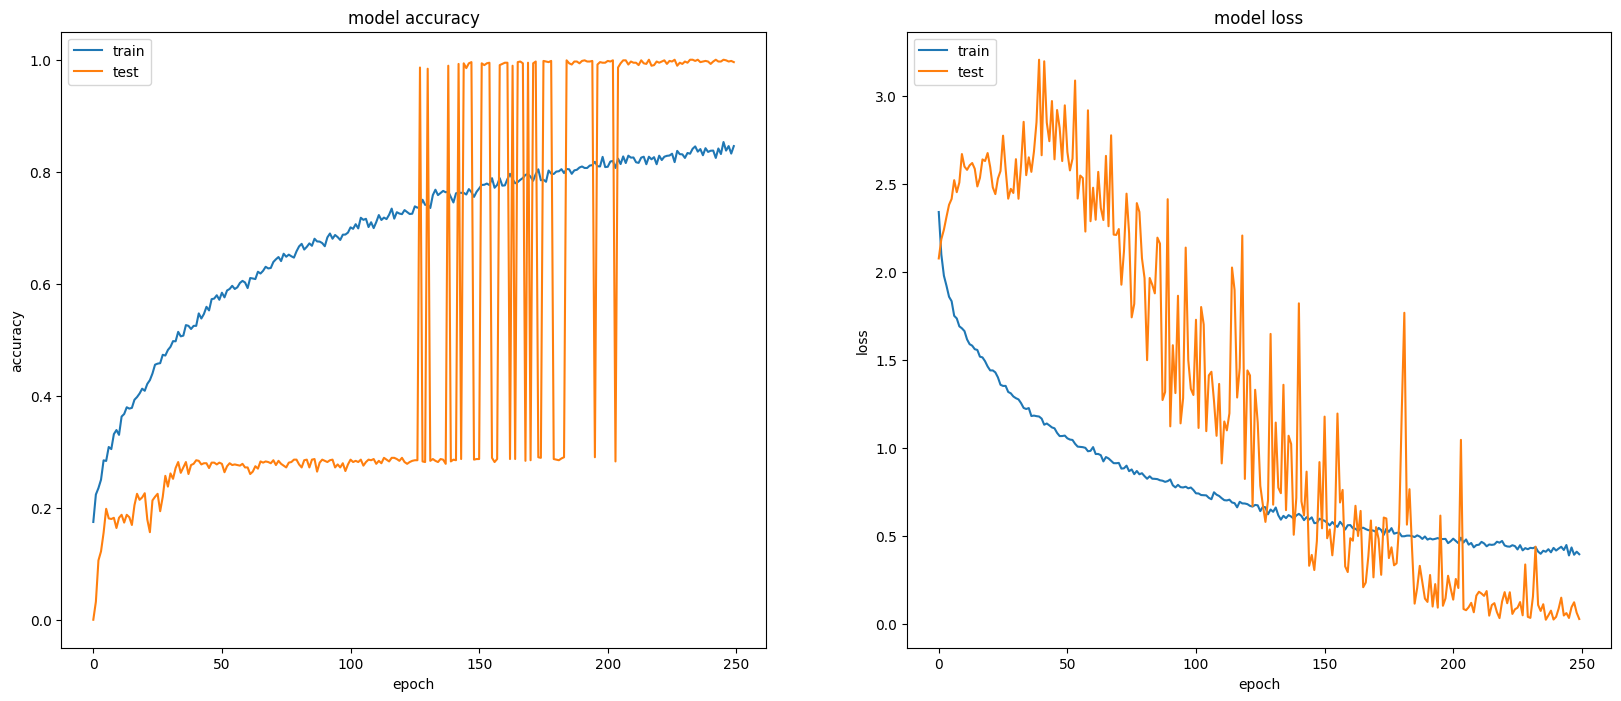

In [52]:
learningRate=best_model['learningRate']/50
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

37/37 [==============================] - 0s 915us/step - loss: 0.5122 - accuracy: 0.8033


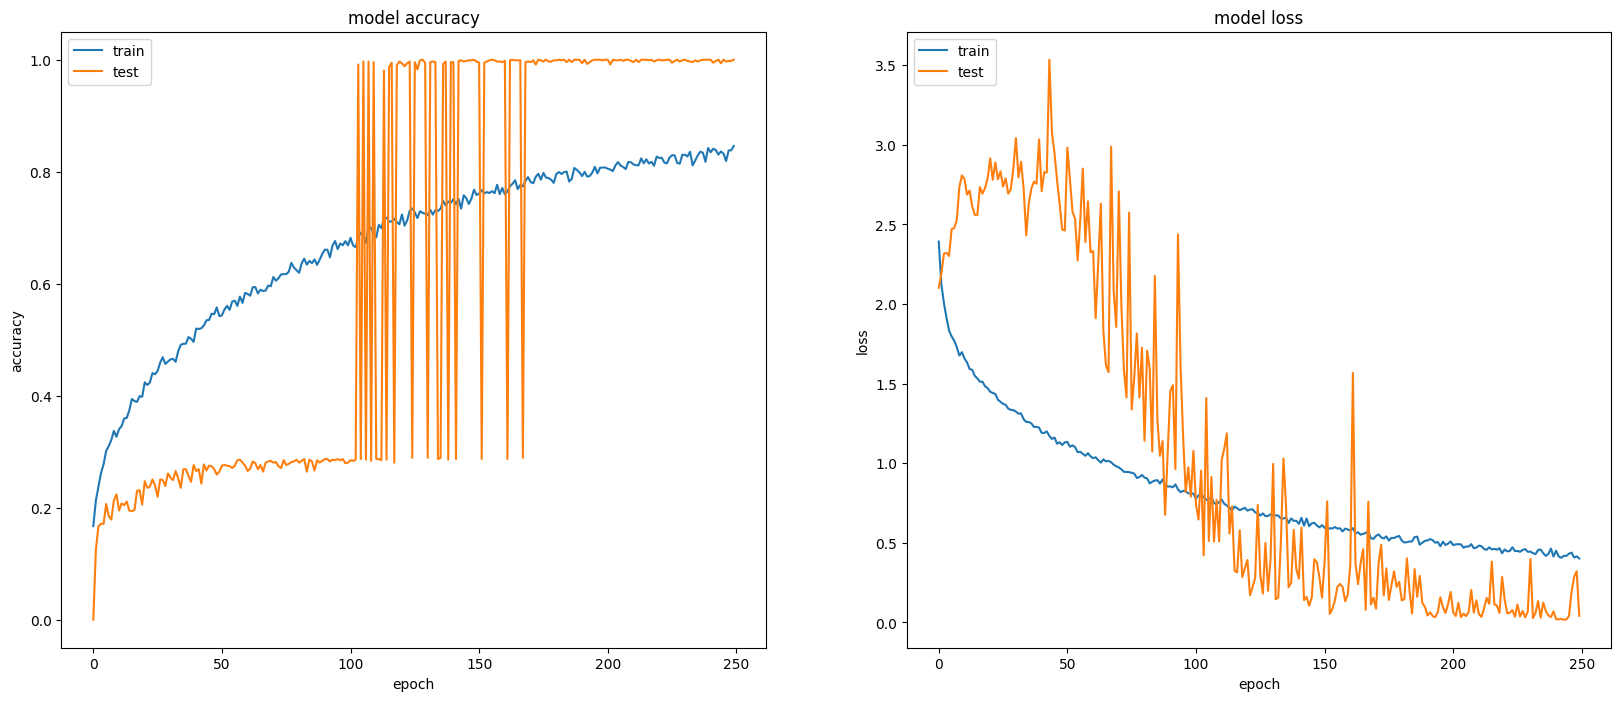

In [53]:
learningRate=best_model['learningRate']/100
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)
plot_acc_loss(history)

In [54]:
best_model = get_best_acc_model(models)
best_model

{'layers': [(500, 'relu'),
  (300, 'relu', 0.3),
  (100, 'relu', 0.25),
  (50, 'relu')],
 'optimizer': 'nadam',
 'batchSize': 32,
 'learningRate': 0.0001,
 'epochs': 250,
 'endActi': 'softmax',
 'best_loss': 0.4815239906311035,
 'best_accuracy': 0.8331907391548157,
 'loss': [2.3039188385009766,
  2.037271022796631,
  1.9337007999420166,
  1.8605705499649048,
  1.8257896900177002,
  1.7707691192626953,
  1.7411621809005737,
  1.703710913658142,
  1.6819003820419312,
  1.6446017026901245,
  1.6272412538528442,
  1.5923216342926025,
  1.5710728168487549,
  1.5641824007034302,
  1.533457636833191,
  1.5383498668670654,
  1.5134893655776978,
  1.4841009378433228,
  1.4793750047683716,
  1.4495772123336792,
  1.4344940185546875,
  1.4064364433288574,
  1.4099637269973755,
  1.3850597143173218,
  1.3728086948394775,
  1.3638174533843994,
  1.3461710214614868,
  1.3416246175765991,
  1.324190616607666,
  1.306721806526184,
  1.2910927534103394,
  1.285961389541626,
  1.2408037185668945,
  1.27

In [55]:
layers = best_model['layers']
model, history = create_fit_model(input_data=X_train_bal, output_data=y_train_bal, layers=layers, optimizer=best_model['optimizer'], endActi=best_model['endActi'], learningRate=best_model['learningRate'], batchSize=best_model['batchSize'], epochs=best_model['epochs'], verbose=0, withHistory=1)

37/37 [==============================] - 0s 876us/step - loss: 0.4836 - accuracy: 0.7998


## Save the best model

In [56]:
model.save('best_model')
model = 0

INFO:tensorflow:Assets written to: best_model/assets


## Load the best model

In [57]:
model = keras.models.load_model('best_model')

## Analyse the model

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analyse_my_mode(model, history):
    model.summary()
    print("\n")
    predictions = model.predict(X_test_bal, verbose=0)
    y_pred = (predictions > 0.5)
    y_test_=y_test_bal.astype(int).tolist()
    print(confusion_matrix(y_test_, y_pred.argmax(axis=1)))
    print("\n")
    print(classification_report(y_true=y_test_,y_pred=y_pred.argmax(axis=1), target_names=y_labels,zero_division=0))
    print("\n")
    
    plot_acc_loss(history);

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 500)               3000      
                                                                 
 batch_normalization_87 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                                 
 dense_118 (Dense)           (None, 300)               150300    
                                                                 
 batch_normalization_88 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 300)               0         
                                                                 
 dense_119 (Dense)           (None, 100)             

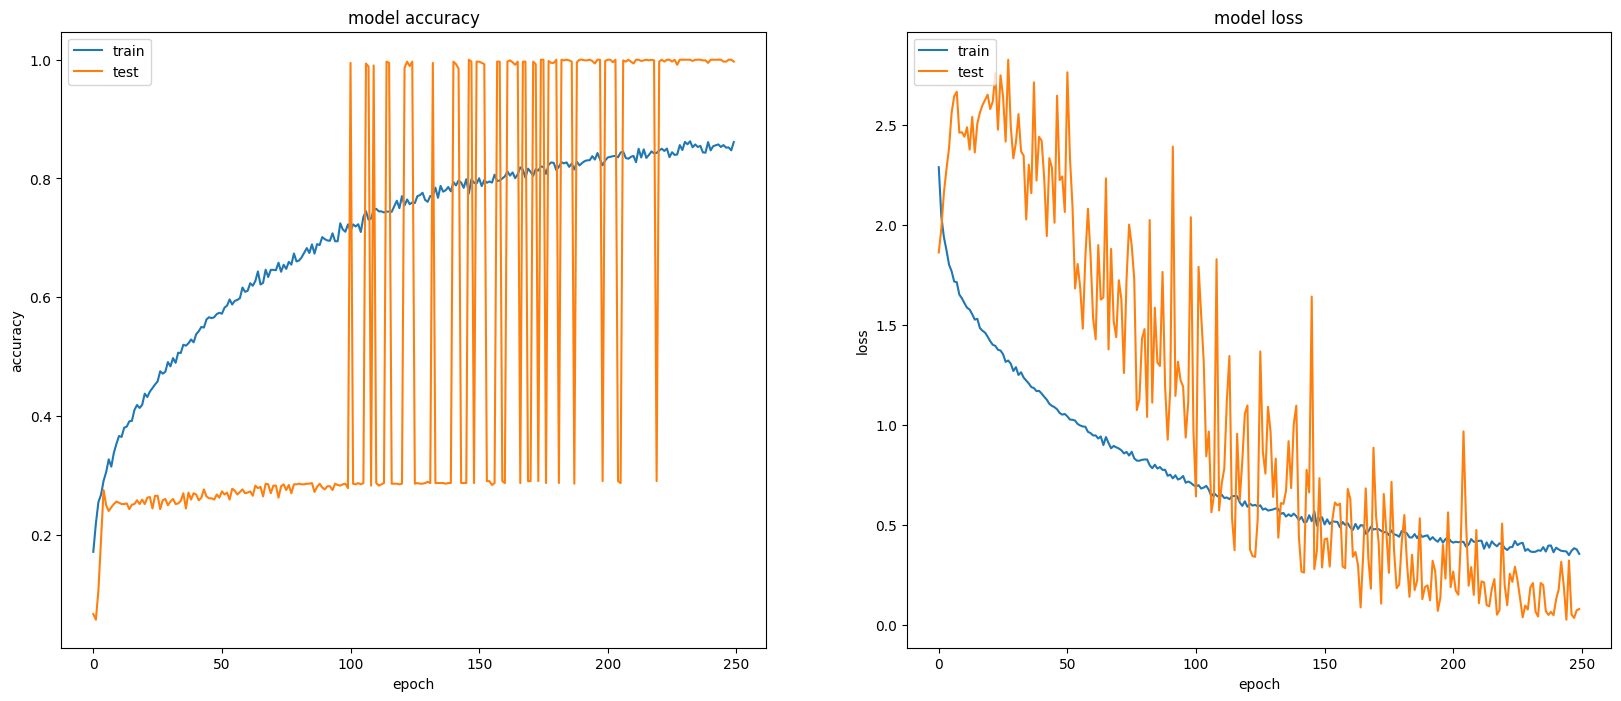

In [59]:
analyse_my_mode(model, history)

The following graph shows the different loss curves. We see we are close but there is still room for improvement. 

<img src="https://cs231n.github.io/assets/nn3/learningrates.jpeg">
(Effect of Learning rate on Loss (Source: CS231n Convolutional Neural Networks for Visual Recognition))

##  Model test

Finally, we test our model a little bit. For this we create a function that randomly creates five different cube values. We also plot the first predictions of the test data to visualize the accuracy.

In [60]:
def predict_result(dices, printResult=False):
    dices = tf.keras.utils.normalize(dices)
    
    _ = model.predict([[dices[0][0], dices[0][1], dices[0][2], dices[0][3], dices[0][4]]], verbose=0)
    
    if printResult:
        return _
    
    result = y_labels[np.argmax(_, axis=1)[0]]

    print(result)

In [61]:
diceOne = np.random.randint(low=1, high=6)
diceTwo = np.random.randint(low=1, high=6)
diceThree = np.random.randint(low=1, high=6)
diceFour = np.random.randint(low=1, high=6)
diceFive = np.random.randint(low=1, high=6)

print([diceOne,diceTwo,diceThree,diceFour,diceFive])
predict_result([diceOne,diceTwo,diceThree,diceFour,diceFive])

[5, 4, 4, 1, 5]
nothing


In [62]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(7), fontsize=10)
  plt.xticks(rotation=90)
  plt.yticks([])
  thisplot = plt.bar(y_labels, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [63]:
#Basic from: https://www.tensorflow.org/tutorials/keras/classification
def plot_bars(num_rows=5, num_cols=3):
    predictions = model.predict(X_test)
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 3*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, num_cols, i+1)
      plot_value_array(i, predictions[i], y_test_bal.reset_index(drop=True))
      if type(X_test_bal) is not np.ndarray:
          dices = np.array(X_test_raw.reset_index(drop=True))[i]
      else:
          dices = np.array(X_test_bal)[i].astype(int)
      title = str(dices[0]) + "," + str(dices[1]) + "," + str(dices[2]) + "," + str(dices[3]) + "," + str(dices[4])
      plt.title(title)
      plt.subplots_adjust(hspace=1.2)
    plt.show()

37/37 [==============================] - 0s 889us/step


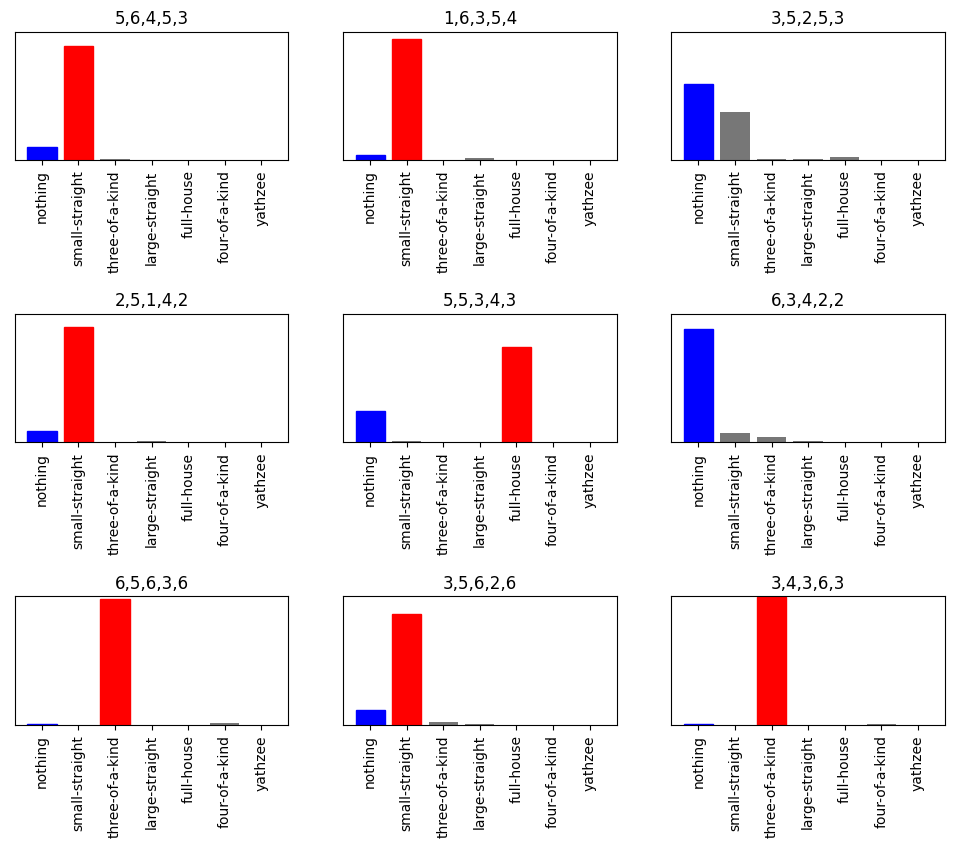

In [64]:
plot_bars(3,3)

## Conclusion

After we loaded the data, our first step was to analyze the data. The data set consists of 5832 entries with 7 different classes. All columns are complete with integer values from 1 - 6 representing the dice rolled. However, the occurrences of each class are very unbalanced. For example, there are 3868 entries of the class "nothing" and only 4 of the class "yathzee", which is about 66% to 0.1% in ratio.

So in order for our model to train reasonably we had to balance the dataset using over and undersampling. However, we split the data set into training and test data beforehand to avoid overfitting and to not falsify our result in the end. We chose a common 80/20 distribution in training and test data. In addition, we normalized the data using the function provided by Keras. This gave an accuracy boost of up to 10%!

The balancing was done as follows: We took the average of the class occurrences and then checked each class if its occurrence was below or above this limit. Depending on this, we then over-sampled using SMOTE and under-sampled using Cluster Centroids. Randomly selected entries are duplicated or removed. In the end, for our training set, we had 667 records per classes and 167 records for each class in the test set.
Small note: For the over and undersampling it was necessary. That there are at least two records per class, Which is why we had to check if this was the case after splitting the raw data.

The next step was to define the different models with the different layers to try some experiments. We chose the optimizer "Adam" as default parameter and start with a batch size of 128 and 250 epochs. The last activation function is always the "Softmax" function, unless otherwise specified. After some tests we found out that a BatchNormalization layer pushes the final result very well, so we add this layer automatically after each hiddenlayer.

The first experiments start with only one input layer and one output layer. The activation function is the "Relu". This is mainly because the "Relu" function is highly recommended on the internet. We tried different numbers of neurons and found that the result increases with increasing number of neurons. Thus, the result with 10,000 neurons is much better than with only 10 neurons. However, the time to compute also increases with the number. We did the following experiments first with neurons in the thousands, but had to realize that the time to calculate everything was very high and the final result was not really better than with less neurons. For this reason we did the following experiments with neurons mi hundreds range. 

The next experiments were with different activation functions. We found out that for one layer the activation function is not so relevant because each result is not good. It is noticeable that the training data produces a quite nice loss curve but the test set is very unusual. This is probably due to the size of the test set and the distribution of classes (although the set is balanced, there were only two "yathzees" and hundreds of "nothings" at the beginning).

Section 3 with the experiments refers to several levels but without dropout. Here the models delivered the first quite good graphs and final results. We get above 70% accuracy for the first time. Then we took the same configuration of the models and added a dropout arbitrarily. Whereby the configuration for "relu" "tanh" and "sigmoid" are always the same to make a better comparison. The models with dropout gave slightly better results. However, the feeling was that even here the dataset is too small and the neuron count too low, so dropout makes quite little sense in this environment.

Having found a model that gives the best values so far, we are now testing this model with different batch sizes and epochs. It is clear that the smaller the batch size and the larger the number of epochs, the higher the accuracy. However, the relation to the used time must be correct. We see for example that the BatchSize 512 is much too large and also not more than 250 epochs are needed.

With the optimizers, we see that "Adam" and "Nadam" give pretty much the same results. The "Sgd" and the "adagrad" optimizers, on the other hand, are not suitable for our model and worsen our results significantly. The last experiments were related to the learning rate. We check if higher or lower learning rate changes anything with the best model. The result was that the learning rate affects the result from 0.72% to 0.8%. 

**Our best model:**
We exported our best model and imported it again (as it was written in the task). Our best model has an input layer with 500 neurons and the "Relu" activation function. After that there are 3 hidden layers with 300, 100 and 50 neurons respectively and all of them also use the "Relu" activation function. The second hidden layer has a dropout of 30% and the third hidden layer has a dropout of 25%. The last layer has a "Softmax" activation function. The BatchSize is 32, the learning rate is 0.0001 and the model has been trained 250 epochs. Our model gives us an accuracy of about 80%. The analysis of the model shows that the class "Yahtzee" has a f1-Score of 1. The model has the biggest problems with the prediction of the classes "Nothing", "small-straight" and "large-straight".